# Sandbox for manually extracting spectra
### Olivia Cooper
### June 2022

In [3]:
# the basics

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import pandas as pd
import astropy
from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import ZScaleInterval
from astropy.stats import sigma_clip
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import read_mospy_files as rmp ## script I made to read in mospy files
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from scipy.ndimage import gaussian_filter1d
plt.style.use('../cooper-paper.mplstyle')

In [2]:
#notes = Table.read('../wmmc01/cooper_notes_wmmc01.csv',format='csv')
notes = Table.read('cooper_full_notes.csv',format='csv')

notes

<Table length=330>
 mask  slit_no            obj             c2020_id ypix_mospy ... spat_fracpos box_width opt_fwhm   s2n   maskdef_extract
 str6   int64            str26             int64     int64    ...   float64      int64   float64  float64       str5     
------ ------- -------------------------- -------- ---------- ... ------------ --------- -------- ------- ---------------
wmmc01       1                 M_WP551495   551495       2219 ...        0.481         1      0.3    0.03            True
wmmc01       2                 B_WP450980   450980       2166 ...        0.552         1      0.3    0.04            True
wmmc01       2                   SERENDIP       --       -999 ...        0.413         3    0.449   -3.25           False
wmmc01       3                    star_75       --       2112 ...        0.464         1    0.456   27.34            True
wmmc01       4                 L_WP693466   693466       2050 ...        0.612         1      0.3    0.26            True
wmmc01       4                   SERENDIP       --       2001 ...           --        --       --      --              --
wmmc01       5 c2020_pz_0.664_22.8_826089   826089       1970 ...        0.464         1      0.3    0.85            True
wmmc01       6                 L_WP930991   930991         -- ...        0.536         1      0.3   -0.01            True
wmmc01       7  c2020_pz_1.65_22.6_640174   640174       1869 ...        0.556         1      0.3    0.61            True
wmmc01       8  c2020_pz_4.25_27.1_702146   702146         -- ...         0.56         1      0.3    0.02            True
wmmc01       9 c2020_pz_0.486_24.7_889105   889105       1724 ...        0.571         1      0.3    0.13            True
wmmc01      10  c2020_pz_4.82_26.4_510074   510074         -- ...         0.52         1      0.3    0.04            True
wmmc01      11                 CAND_M8502       --       1581 ...        0.536         1      0.3    0.13            True
wmmc01      12  c2020_pz_4.11_25.3_592463   592463         -- ...          0.5         1      0.3    0.07            True
wmmc01      13                 L_WP737150   737150         -- ...         0.66         1      0.3   -0.14            True
wmmc01      14                 CAND_L4510       --         -- ...         0.56         1      0.3   -0.02            True
wmmc01      15  c2020_pz_1.95_23.1_891793   891793       1292 ...        0.536         1      0.3    0.41            True
wmmc01      16  c2020_pz_4.33_0.00_829943   829943         -- ...          0.7         1      0.3   -0.02            True
wmmc01      16                   SERENDIP       --       1216 ...           --        --       --      --              --
wmmc01      17                 B_WP547670   547670       1119 ...         0.44         1      0.3   -0.14            True
wmmc01      17                   SERENDIP       --       1159 ...           --        --       --      --              --
wmmc01      18                 CAND_M5825       --       1041 ...        0.464         1      0.3    0.08            True
   ...     ...                        ...      ...        ... ...          ...       ...      ...     ...             ...
wmme03      15                NSFil_24405       --         -- ...        0.556         2      1.0    0.14            True
wmme03      16                   SERENDIP       --         -- ...           --        --       --      --              --
wmme03      16                NSFil_21505       --         -- ...        0.556         2      1.0    0.24            True
wmme03      17                NSFil_37851       --         -- ...        0.418         2      1.0   -0.11            True
wmme03      18                NSNew_16149       --         -- ...        0.463         2      1.0   -0.03            True
wmme03      19                   SERENDIP       --         -- ...           --        --       --      --              --
wmme03      19      NSFin_EGS_SF_z4_59741       --         -- ...        0.36

In [32]:
idx = 33
obj_name = notes['obj'][idx]; zguess = float(notes['zmeasured'][idx]); lguess = float(notes['wave'][idx])
print('working on object',obj_name,'with zguess = ',zguess,'at lambda = ',lguess,'AA')
lguess

working on object c2020_pz_4.45_25.8_938343 with zguess =  nan at lambda =  9864.0 AA


/var/folders/pg/yy4jmlqx6jdd_b30vyvvg93h0000gq/T/ipykernel_44719/1038800376.py:2: UserWarning: Warning: converting a masked element to nan.
  obj_name = notes['obj'][idx]; zguess = float(notes['zmeasured'][idx]); lguess = float(notes['wave'][idx])


9864.0

In [3]:
#M_W69492
pyp1 = fits.open('../wmme01/pypeit_products/Science_coadd_1x1/spec2d_m220314-m220214-wmme01.fits')

In [9]:
import glob
mask='wmmc01'
file = glob.glob('../'+mask+'/spec2d*.fits')[0]
pyp1 = fits.open(file)
pyp1

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f8243ba37f0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f823017ccd0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f823017cd30>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f8230121070>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f82301211f0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f823017ce20>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f823017cf70>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f8230121550>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f82301214f0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f8230121250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f8230121700>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f8230121ac0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f8230121d00>]

In [10]:
obj_name = 'M_WP551495'
notes = Table.read('cooper_full_notes.csv',format='csv')
idx = np.where(notes['obj']==obj_name)[0]
zguess = float(notes['zguess'][idx])
lguess = float(notes['wave'][idx])
xcen = int(2278)
pid = int(notes['pypeit_ref_idx'][idx])-1
print('working on object',obj_name,'with zguess = ',zguess,'at lambda = ',lguess,'AA and pypeit xpix = ',xcen)

working on object M_WP551495 with zguess =  7.43 at lambda =  10263.0 AA and pypeit xpix =  2278


In [11]:
d1 = Table.read('../wmmc01/'+obj_name+'_1dspec.txt',format='ascii')
hdu1 = fits.open('../wmmc01/spec1d_m220212-m220212-wmmc01.fits')
pyp1[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
VERSPYT = '3.9.12  '           / Python version                                 
VERSNPY = '1.22.3  '           / Numpy version                                  
VERSSCI = '1.8.0   '           / Scipy version                                  
VERSAST = '5.0.4   '           / Astropy version                                
VERSSKL = '1.0.2   '           / Scikit-learn version                           
VERSPYP = '1.8.2.dev225+g3d85b1575' / PypeIt version                            
DATE    = '2022-05-23'         / UTC date created                               
LONGSTRN= 'OGIP 1.0'                                                            
EXTVER  =                   

In [12]:
d1

<Table length=1021>
      lambda        pix       opt_counts      ...       box_counts          box_sigma         box_sky_counts   
     float64       int64       float64        ...        float64             float64             float64       
------------------ ----- -------------------- ... --------------------- ------------------ --------------------
 9412.833622339405     1   0.9725032469274703 ...     1.623423361563354  1.768952898875885  0.19872700621024647
 9415.021844437002     2  -1.2499531206274663 ...     0.717742343979913  2.098883475099309    1.817753743938039
 9417.181442411676     3  -0.5702759596624248 ...     1.087223491957767 2.0602902373174614  0.10921178425559694
 9419.330061793866     4   1.4095045747357653 ...    1.5176048312752806  1.662995997996807  -0.2916866848757729
 9421.442575642148     5   1.4065050558552081 ...    2.6893024220468487 1.9612981215692495   0.7967911698759607
 9423.543284200789     6 -0.11719524900168847 ...   -0.9206093525978736 1.7613385984338155  -0.7338828485773139
 9425.591403685801     7   0.8662584850901346 ...     2.405200601665171  2.358468719076284  0.18189540837446633
 9427.728005183946     8  -3.0122557567672925 ...    -7.097918954628606 2.7138815006643973 0.014488235708385134
 9429.819378553238     9  -1.9604205788372677 ...   -1.8984955543169486 1.6814022469684318    1.898402777989248
 9431.958255585496    10  -2.2763440493763962 ...   -3.6973171764577666 1.4680644253665824   0.3304265773703329
 9434.074952846895    11   1.1480122659325984 ...    1.3507013974423667 1.6956048503854377   -2.432987457263664
 9436.187755025789    12  -0.2834191653712121 ... 0.0027359287430288592 1.9559008373940356  -1.5401106645470315
  9438.27464421769    13   0.5419353108695049 ...    1.2351646758207278 1.6394623611418249  -0.7880668102197241
 9440.432312519113    14   0.8566662161238706 ...  -0.22067391341317533  2.067754855895179  0.38216709757863665
 9442.622213905697    15  0.23603919773848353 ...   0.15603267029725165 2.8408775557614305  -0.1074555670120127
  9444.78578298334    16  -1.1449875268072993 ...   0.12615220903241725  1.836798978439965    1.210178510259369
 9447.006021219662    17 -0.28661413622319415 ...   0.08274806946241786 1.3822902581248229  -0.7359344407992173
 9449.164513472184    18  -0.6131929641439156 ...   -0.9781529141174177  1.398050731962417  -0.4300507810440798
 9451.354963750808    19   -2.311761445600427 ...   -2.0725807726884313   1.37540890886013   1.6240389324340492
 9453.561731642598    20   1.6599204139506645 ...    2.3436454643460447 1.3411721409040027  -1.2264350593039681
 9455.752038448176    21   -0.876507324194008 ...   -1.1832667166948476  1.349687285673931  0.08817234087708889
 9457.951312756668    22  0.30184185893538223 ...    0.4670878048003375 1.3774802019655519 -0.18428725807417307
               ...   ...                  ... ...                   ...                ...                  ...
11580.191701598675   999   0.5461048398522687 ...  -0.08413896006616131 1.4389566084615326   0.9787136067328932
11582.444890756587  1000  -0.9272477445060341 ...   -1.7082580708905983 1.4447256834756828   1.2939739150785678
 11584.69010789514  1001  -1.1569891982716587 ...  -0.14257554532193706 1.3767985315114475  -1.2119588180784246
11586.892923670173  1002  0.28870994461448624 ...    1.9247945250396516  1.508547571410313  0.24722617834342925
11589.058109911224  1003   2.0021470039740654 ...    1.7894415692576076 1.4961089309607116  -2.0770710788406155
11591.217475216838  1004  -2.2736756997118213 ...    -2.475530626704006 1.4463368084955068   0.8288984717225054
11593.316908949717  1005  -1.2684534679066017 ...   -1.9177667005748011  1.601254776798636    1.208642825988383
11595.551045116325  1006   0.7235280439762447 ...    0.8637926704038265 2.5776284687680806  0.00511667471707733
11597.766628925896  1007  -1.6308761132609408 ...  -0.28956627170323984 3.7013887117262505  -0.3977670700519541
11600.006221638258  1008  -0.5336740866064372 ...   -3.06507

In [13]:
header = pyp1[0].header
signal = pyp1[1].data
wave = pyp1[8].data
error = pyp1[3].data

In [370]:
(xcen-x1) / (x2-x1)

0.5

In [18]:
pyp1[10].data[pid-2]

(1504, 1, 13.0, array([13., 13., 13., ..., 13., 13., 13.]), array([1491., 1491., 1491., ..., 1491., 1491., 1491.]), array([1518., 1518., 1518., ..., 1518., 1518., 1518.]), array([1504.5, 1504.5, 1504.5, ..., 1504.5, 1504.5, 1504.5]), 0, 0, 0.0, 1025.0)

In [14]:
ref = pyp1[10].data[pid]
x1 = ref[4][0]
xcen = ref[6][0]
x2 = ref[5][0]
sig2d = signal[0:,int(x1):int(x2)].T
plt.imshow(sig2d)

IndexError: index 33 is out of bounds for axis 0 with size 32

candidate line at  10304.0 AA;  1043 pix


Text(998, 0.065, 'z = 7.4775')

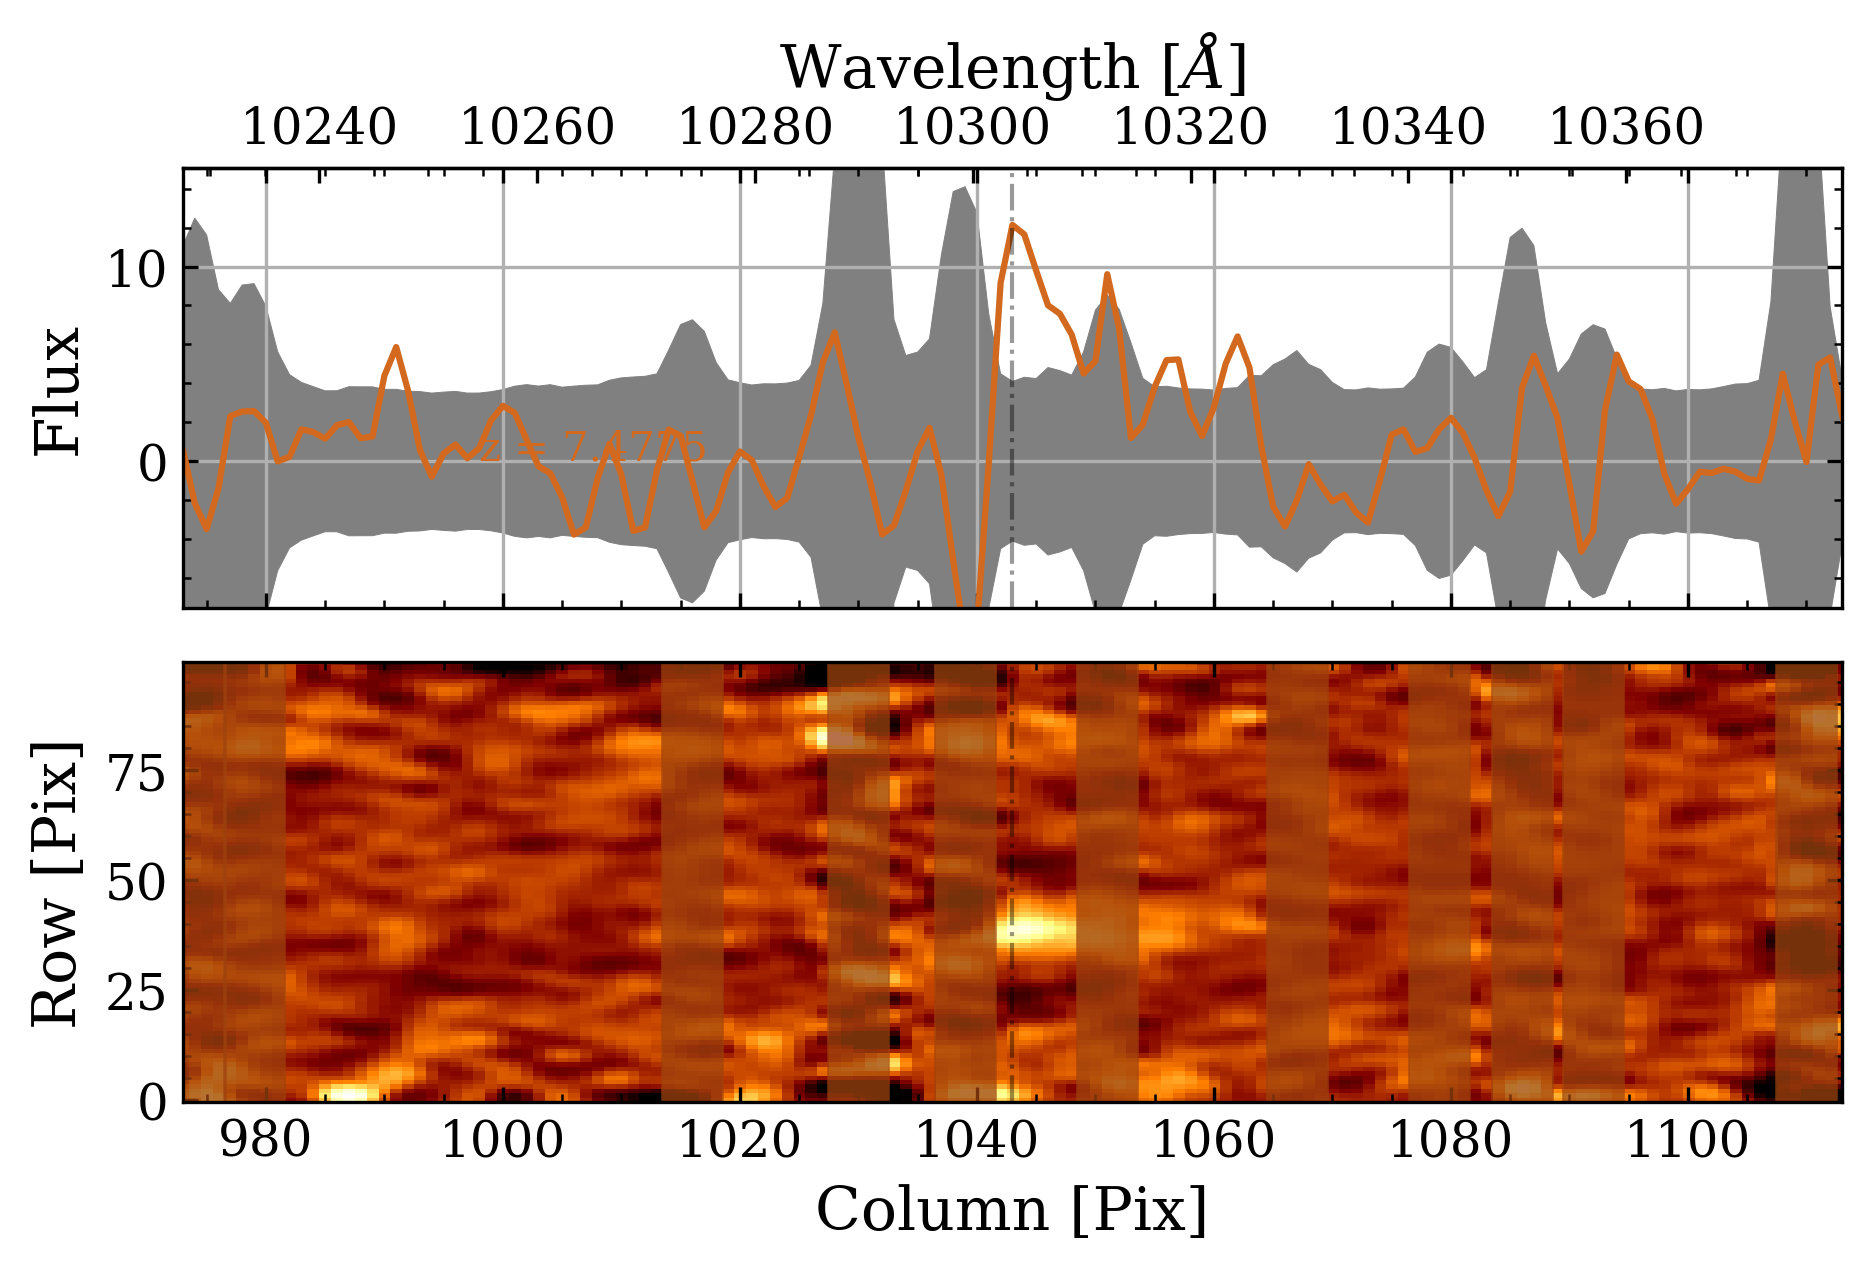

In [11]:
ycen = 50
pixscale = pyp1[0].header['PSCALE'] # arcsec/pix
slitwidth = 2.5 # arcsec
nodamp = slitwidth/pixscale # nod amplitude in pixels
pix = np.zeros_like(d1['lambda'])
# gaussian smooth 2D spec
kernel = Gaussian2DKernel(x_stddev=1.5)
conv_im = convolve(sig2d, kernel)

### START FIG!
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

# 1D spec
ax1.plot(d1['pix'],gaussian_filter1d(d1['opt_counts'],sigma=1),c='chocolate',label=obj_name)
#ax1.plot(d1['lambda'],spec+rms,c='chocolate',ls='--',alpha=0.6) 
ax1.fill_between(d1['pix'], y1=d1['opt_sigma'], y2=-1*d1['opt_sigma'], color='gray', label='sky')
ax1.set_ylabel(r'Flux')

# 2D spec
lower=-1; upper=2
sample = sigma_clip(sig2d) 
vmin = sample.mean() + lower * sample.std()
vmax = sample.mean() + upper * sample.std()
ax2.imshow(conv_im, origin='lower', cmap='afmhot', aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_xlabel('Column [Pix]')
ax2.set_ylabel('Row [Pix]')
ax2.grid(False)

# block out sky lines 2D
ipk = find_peaks(d1['opt_sigma'], height=np.mean(d1['opt_sigma']))[0]
for i in ipk:
    ax2.axvline(d1['pix'][i],c='#9E420E',lw=15,alpha=0.75)

    
# secax = secondary axis for wavelength space
def forward(x):
    return np.interp(x, d1['pix'], d1['lambda'])

def inverse(x):
    return np.interp(x, d1['lambda'], d1['pix'])

secax = ax1.secondary_xaxis('top', functions=(forward, inverse))
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel(r'Wavelength [$\AA$]')

# mark measured line at pixel guess based on lambda guess
pguess = d1['pix'][rmp.closest(d1['lambda'],lguess)[0]] # pixel closest to wavelength of line to center on
print("candidate line at ",lguess,'AA; ',pguess,'pix')
ax1.axvline(pguess,lw=1,c='k',ls='-.',alpha=0.4)
ax2.axvline(pguess,lw=1,c='k',ls='-.',alpha=0.4)

ax1.set_xlim(pguess-70,pguess+70)
ax2.set_xlim(pguess-70,pguess+70)
ax1.set_ylim(-2*np.nanmedian(d1['opt_sigma']),4*np.nanmedian(d1['opt_sigma']))
ax1.annotate('z = '+str(zguess),xy=(pguess-45,0.065),fontsize=10,c='chocolate')

(-10.0, 25.0)

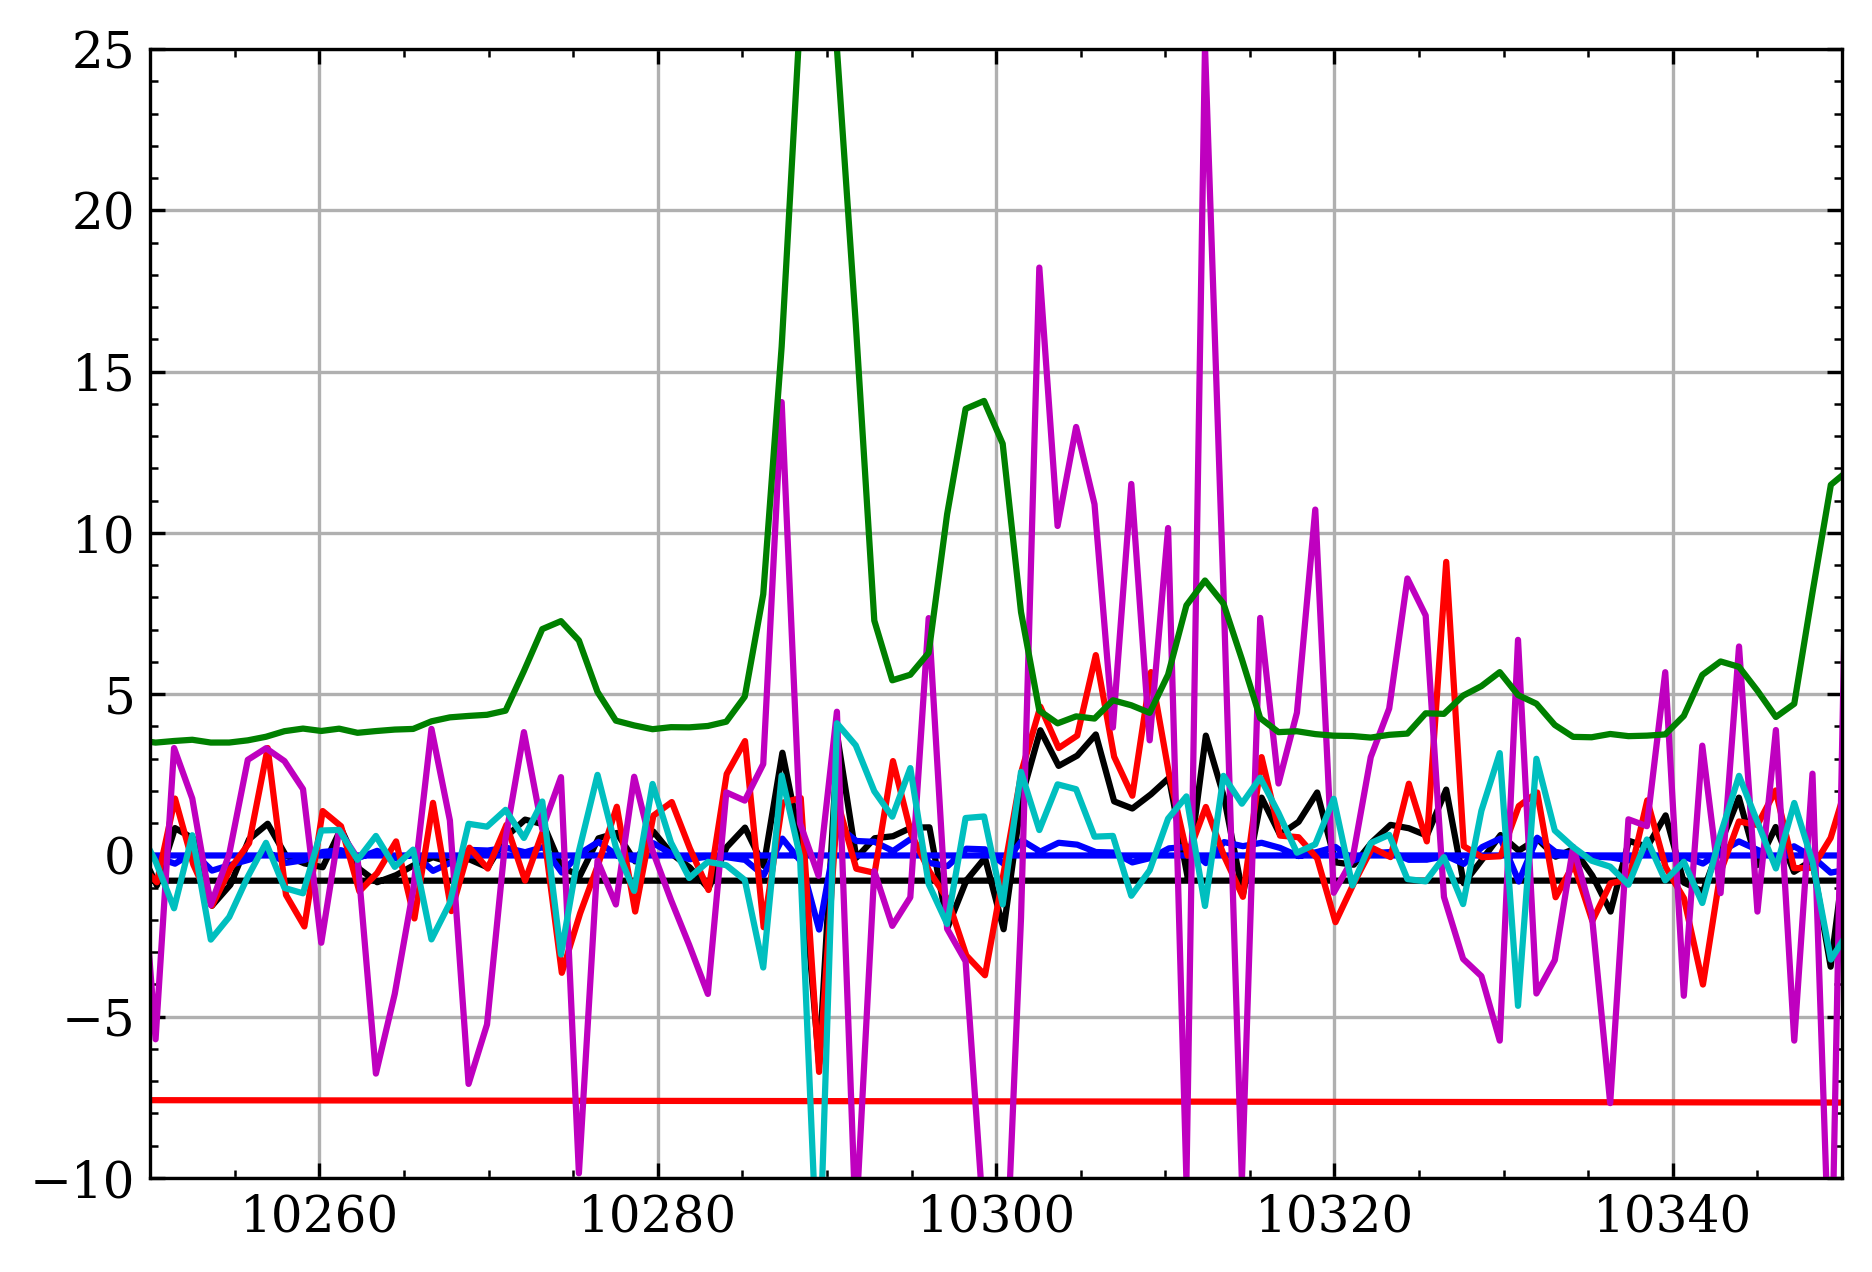

In [296]:
plt.plot(wave[0:,xcen],spec,'k')
plt.plot(wave[0:,xcen],erropt,'b')
plt.plot(wave[0:,xcen],signal[0:,xcen],'r')
plt.plot(d1['lambda'],d1['opt_counts'],'m')
plt.plot(d1['lambda'],d1['sky_counts'],'c')
plt.plot(d1['lambda'],d1['opt_sigma'],'g')
plt.xlim(10250,10350)
plt.ylim(-10,25)

In [248]:
# open 1D and 2D spectrum for an object

hdu2 = fits.open('../wmmc01/wmmc01_Y_'+obj_name+'_eps.fits') # 2D spectrum
hdu1 = fits.open('../wmmc01/wmmc01_Y_'+obj_name+'_1D_00.fits') # 1D spectrum
pix_obj, wav_obj, spec1d_obj = rmp.make_1d_array(ext=0,hdu=hdu1) # object spectrum
pix_sky, wav_sky, spec1d_sky = rmp.make_1d_array(ext=1,hdu=hdu1) # sky spectrum
image = hdu2[0].data
obj_pos = int(notes['spat_fracpos'][idx]*image.shape[0])-18
pixscale = hdu2[0].header['PSCALE'] # arcsec/pix
slitwidth = 2.5 # arcsec
nodamp = slitwidth/pixscale

In [360]:
obj_pos

22

candidate line at  9941.0 AA;  177.0 pix


Text(128.0, 0.15, 'z = 7.175')

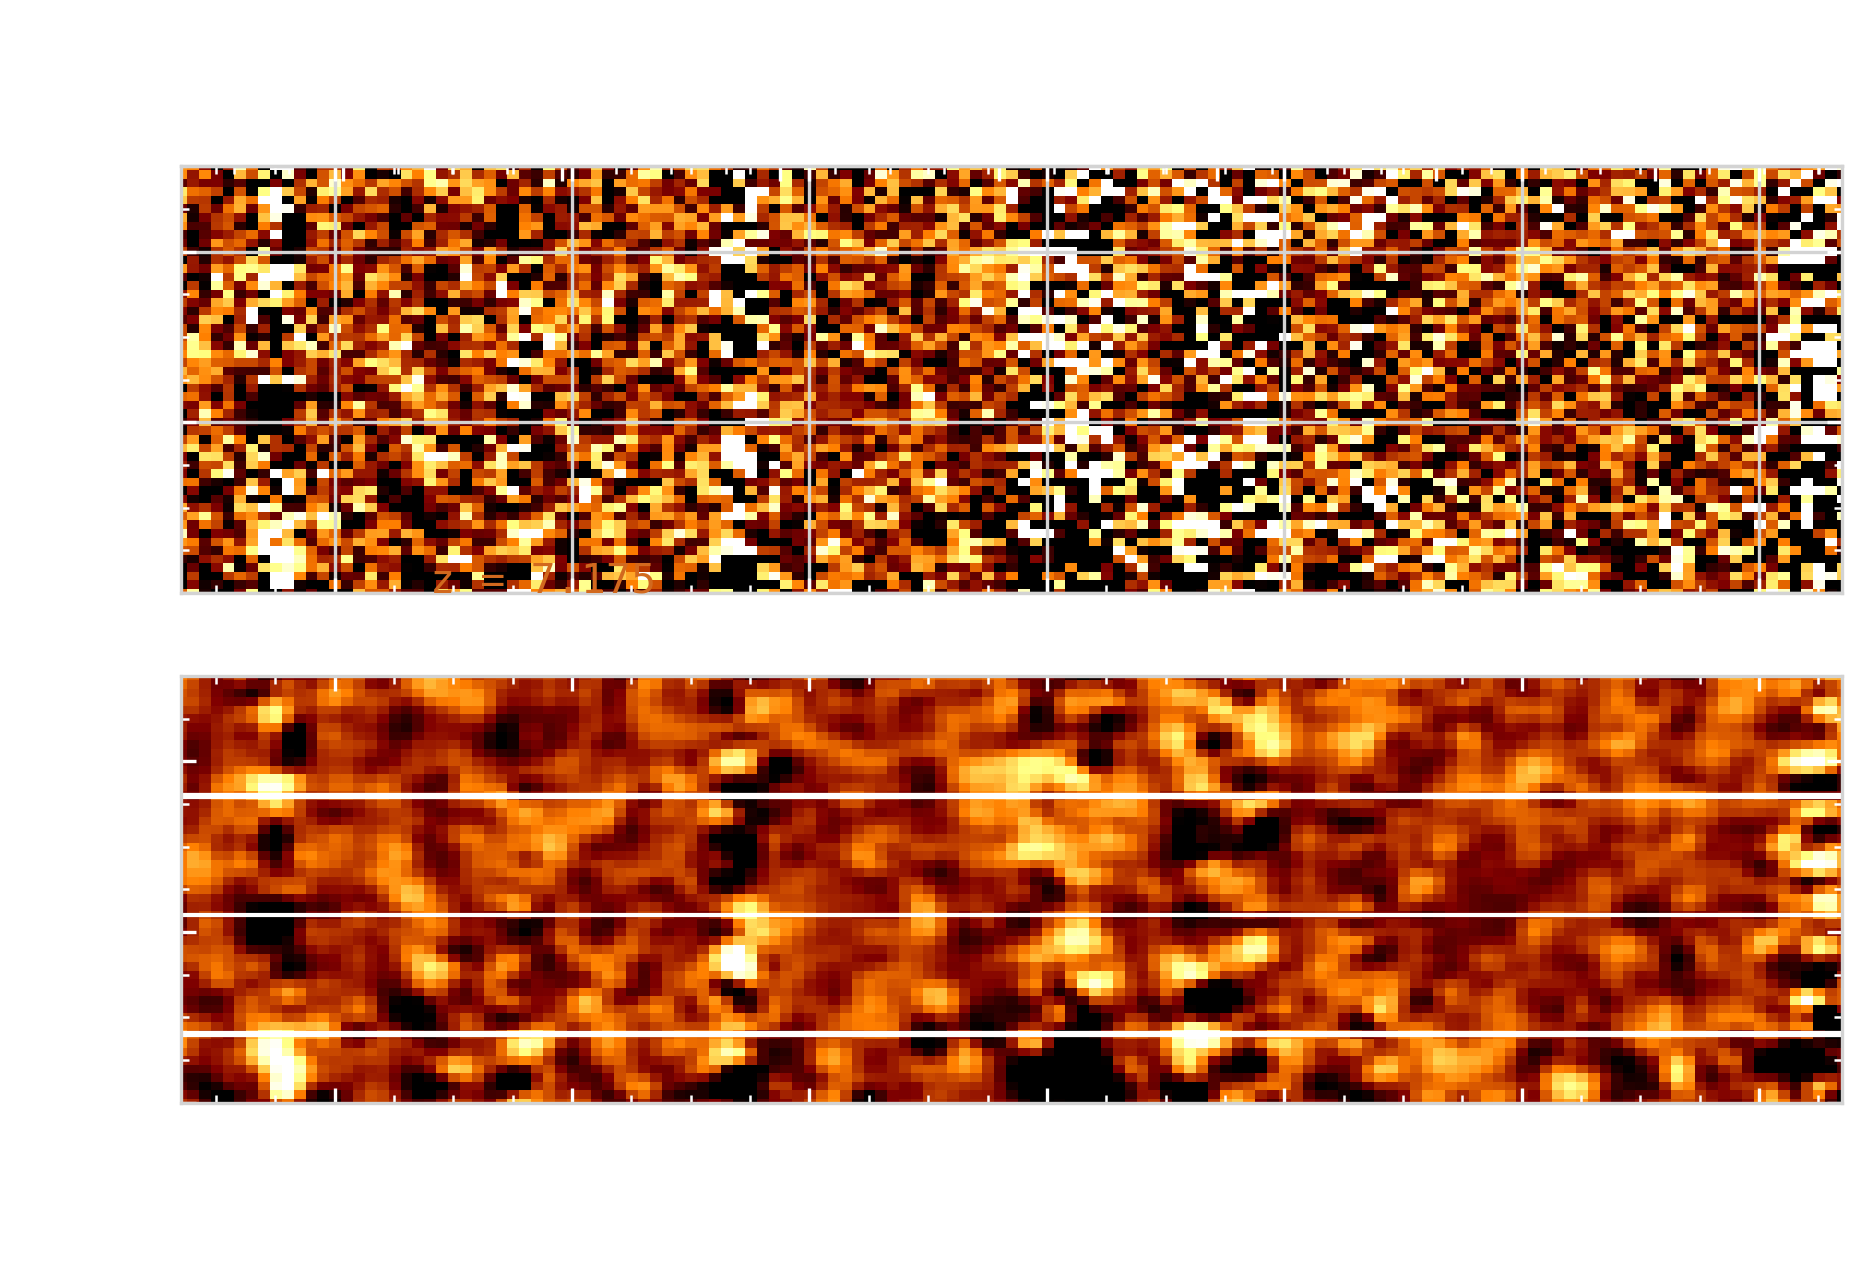

In [249]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

# ax1 = 1d spectrum in pixel space
#ax1.plot(pix_obj,spec1d_obj,c='chocolate',label=obj_name)
#ax1.fill_between(pix_sky, y1=spec1d_sky, y2=0, color='gray', label='sky')
ax1.set_ylabel(r'Flux')

xpix = 472; ypix = 19
### B_WP450980, ypix = 21
### B_WP567863, ypix = 34
#ypix1 = 18; ypix2 = 46
# ax2 = 2d spectrum in pixel space

### gaussian smooth
kernel = Gaussian2DKernel(x_stddev=1)
conv_im = convolve(hdu2[0].data, kernel)

lower=-1; upper=2
sample = sigma_clip(hdu2[0].data) 
vmin = sample.mean() + lower * sample.std()
vmax = sample.mean() + upper * sample.std()
ax1.imshow(hdu2[0].data, origin='lower', cmap='afmhot', aspect='auto', vmin=vmin, vmax=vmax)


ax2.imshow(conv_im, origin='lower', cmap='afmhot', aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_xlabel('Column [Pix]')
ax2.set_ylabel('Row [Pix]')
ax2.grid(False)
#ax2.axhline(ypix,lw=1)

ax2.axhline(obj_pos,lw=1)
ax2.axhline(obj_pos+nodamp)
ax2.axhline(obj_pos-nodamp)
#ax2.axhline(ypix1,lw=1)
#ax2.axhline(ypix2,lw=1)
ax2.axvline(xpix,lw=1)

# secax = secondary axis for wavelength space

def forward(x):
    return np.interp(x, pix_obj, wav_obj)

def inverse(x):
    return np.interp(x, wav_obj, pix_obj)

secax = ax1.secondary_xaxis('top', functions=(forward, inverse))
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel(r'Wavelength [$\AA$]')

# mark measured line at pixel guess based on lambda guess
pguess = pix_obj[rmp.closest(wav_obj,lguess)[0]] # pixel closest to wavelength of line to center on
print("candidate line at ",lguess,'AA; ',pguess,'pix')


### change limits!
ax1.set_xlim(pguess-70,pguess+70)
#ax1.set_ylim(-0.05,0.1)
ax1.set_ylim(0,50)
ax2.set_xlim(pguess-70,pguess+70)
ax2.set_ylim(0,50) 
#ax2.set_ylim(0,93)
ax1.annotate('z = '+str(zguess),xy=(pguess-49,0.15),fontsize=10,c='chocolate')

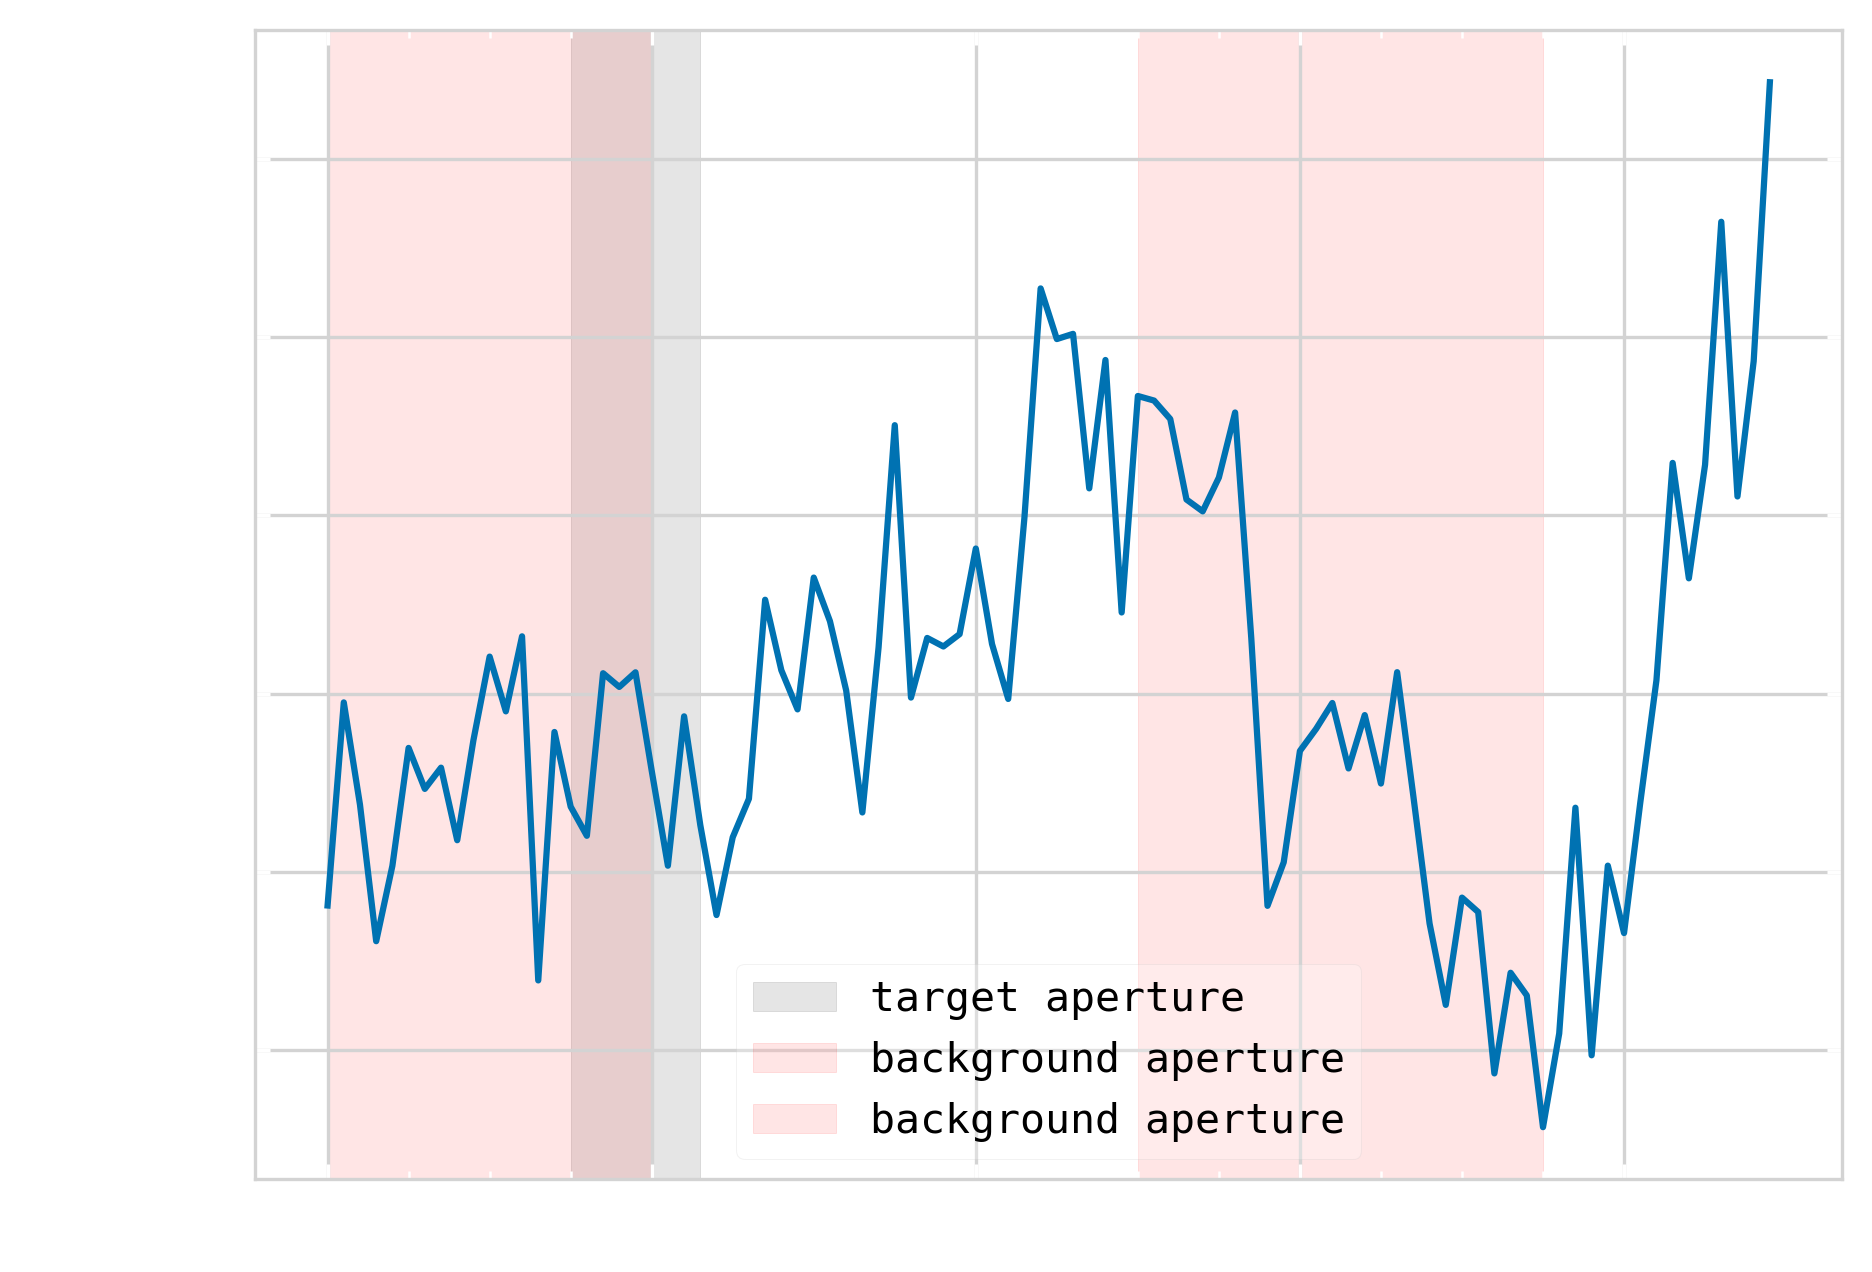

In [252]:
# plot the average of each row vs. row number
plt.plot(image.mean(axis=1))

# define the target aperture range
row1, row2 = ypix-4, ypix+4
row1_1, row2_1 = ypix1-4, ypix1+4
row1_2, row2_2 = ypix2-4, ypix2+4
plt.axvspan(row1, row2, color='k', alpha=0.1, label='target aperture')
#plt.axvspan(row1_1, row2_1, color='c', alpha=0.1, label='lower negative')
#plt.axvspan(row1_2, row2_2, color='c', alpha=0.1, label='upper negative')
spec = np.sum(image[row1:row2, :], axis=0)

# define the background aperture
# (it is best to have two bands--one on each side of the target aperture)
bg_apertures = []
bg_apertures.append((0, 20))
bg_apertures.append((50, 75))
for bgrow1, bgrow2 in bg_apertures:
    plt.axvspan(bgrow1, bgrow2, color='r', alpha=0.1, label='background aperture')

plt.legend();

candidate line at  9941.0 AA;  177.0 pix


Text(132.0, 0.065, 'z = 7.175')

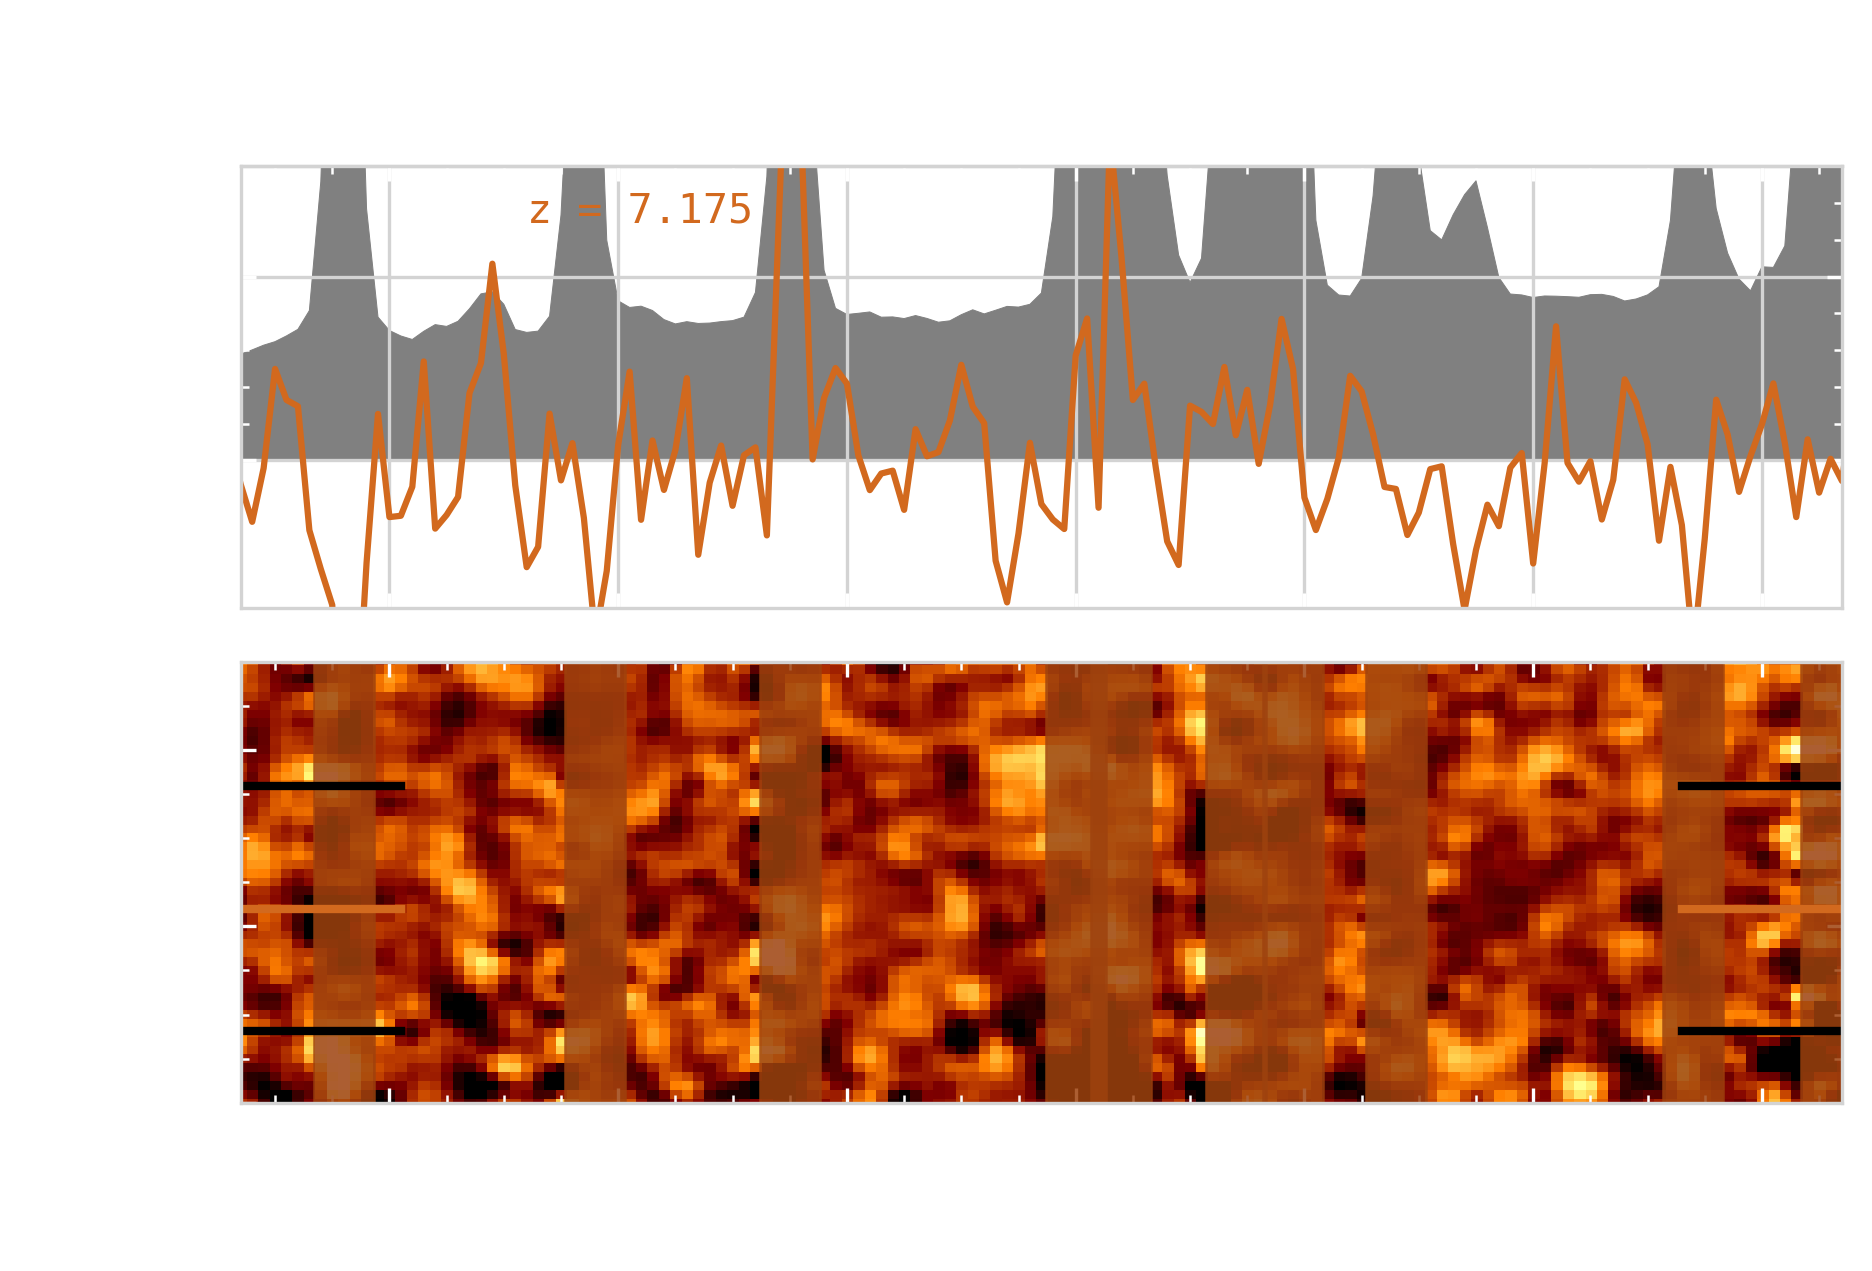

In [359]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

# ax1 = 1d spectrum in pixel space
#ax1.plot(pix_obj,spec1d_obj,c='c',label='auto mospy 1d')
ax1.plot(pix_obj,spec,c='chocolate',label=obj_name)
#ax1.plot(pix_obj,spec1,c='b',label='lower negative')
#ax1.plot(pix_obj,spec2,c='m',label='uppernegative')

ax1.fill_between(pix_sky, y1=spec1d_sky, y2=0, color='gray', label='sky')
ax1.set_ylabel(r'Flux')


### gaussian smooth
kernel = Gaussian2DKernel(x_stddev=1)
conv_im = convolve(hdu2[0].data, kernel)
# ax2 = 2d spectrum in pixel space
lower=-1; upper=2
sample = sigma_clip(hdu2[0].data) 
vmin = sample.mean() + lower * sample.std()
vmax = sample.mean() + upper * sample.std()
ax2.imshow(conv_im, origin='lower', cmap='afmhot', aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_xlabel('Column [Pix]')
ax2.set_ylabel('Row [Pix]')
ax2.grid(False)

ipk = find_peaks(spec1d_sky, height=np.mean(spec1d_sky))[0]
for i in ipk:
    ax2.axvline(pix_sky[i],c='#9E420E',lw=15,alpha=0.85)
#plt.plot(pix_sky,spec1d_sky,'b.')
#ax2.axhline(row1,c='c',lw=1)
#ax2.axhline(row2,c='c',lw=1)
#ax2.axhline(row1_1,c='b',lw=1)
#ax2.axhline(row2_1,c='b',lw=1)
#ax2.axhline(row1_2,c='m',lw=1)
#ax2.axhline(row2_2,c='m',lw=1)
#ax2.axvline(xpix-3,lw=1)
#ax2.axvline(xpix+3,lw=1)
# secax = secondary axis for wavelength space

def forward(x):
    return np.interp(x, pix_obj, wav_obj)

def inverse(x):
    return np.interp(x, wav_obj, pix_obj)

secax = ax1.secondary_xaxis('top', functions=(forward, inverse))
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel(r'Wavelength [$\AA$]')

# mark measured line at pixel guess based on lambda guess
pguess = pix_obj[rmp.closest(wav_obj,lguess)[0]] # pixel closest to wavelength of line to center on
print("candidate line at ",lguess,'AA; ',pguess,'pix')

ax2.axhline(obj_pos,xmin=0,xmax=0.1,lw=2,c='chocolate')
ax2.axhline(obj_pos,xmin=0.9,xmax=1,lw=2,c='chocolate')
ax2.axhline(obj_pos+nodamp,xmin=0,xmax=0.1,lw=2,c='k')
ax2.axhline(obj_pos+nodamp,xmin=0.9,xmax=1,lw=2,c='k')
ax2.axhline(obj_pos-nodamp,xmin=0,xmax=0.1,lw=2,c='k')
ax2.axhline(obj_pos-nodamp,xmin=0.9,xmax=1,lw=2,c='k')



### change limits!
#ax1.legend()
ax1.set_xlim(pguess-70,pguess+70)
ax1.set_ylim(-0.04,0.08)
ax2.set_xlim(pguess-70,pguess+70)
ax2.set_ylim(0,50) 
ax1.annotate('z = '+str(zguess),xy=(pguess-45,0.065),fontsize=10,c='chocolate')

#fig.savefig('plots/wmmc01/'+obj_name+'_manual_boxcar_1D_2D_lines.png',dpi=500)

In [74]:
possum = np.sum(spec[xpix-3:xpix+3])
negsum = np.abs(np.sum(spec1[xpix-3:xpix+3])+np.sum(spec2[xpix-3:xpix+3]))
negsum/possum

1.6457201325093376

In [4]:
# the basics

import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy.table import Table
import extract_1d_spec as ex ### this is the code to do the extraction, go look at the script!
import read_mospy_files as rmp ## script I made to read in mospy files
plt.style.use('../../cooper-paper.mplstyle')

In [99]:
### CHANGE THESE TO MATCH YOUR PATH AND OBJECT YOU WANT

obj_name = 'star_243' ### change me!
dir = '../wmmc03/mospy_products/COMBINED/wmmc03b_COMBINED_' ### change me! this path WILL be different on your computer

In [100]:
aper=5;width=4;obj=obj_name;path=dir;ycen=64
# making sure the aperture is an odd number
assert aper%2 == 1, "Aperture size needs to be an odd number of pixels. "\
    f"Currently, the aperture size is: \n \t\t  aper = {aper} pixels (default is 7 pixels)."

# reading in data
print(f'\nReading in data for {obj}')
header = fits.getheader(path + obj + '_eps.fits')
signal = fits.getdata(path + obj + '_eps.fits')
error = fits.getdata(path + obj + '_sig.fits')
print(f'Dimensions: \t signal spectrum {signal.shape}\n' +
        f'\t\t error spectrum {error.shape}')

wavelength_start = header['CRVAL1'] # starting wavelength at first pixel
wavelength_logdisp = header['CD1_1'] # delta wavelength per pixel
num_wavelength = header['NAXIS1'] # length of data array
wave = wavelength_start + np.arange(0, wavelength_logdisp*num_wavelength, wavelength_logdisp) # wavelength

# defining optimized extraction gaussian
pixscale = header['PSCALE'] # arcsec/pix
fwhm = 0.8 / pixscale # arcsec / [arcsec/pixel]
gauss = ex.gaussian(np.arange(aper),mean=3.,A=1.,sig=fwhm/2.35,offset=0.)
gauss /= sum(gauss) # to make it sum to 1 to use as weights
gauss_2D = np.zeros((len(gauss),len(wave))) # making 2D array of weights
for i in range(aper):
    gauss_2D[i] = gauss[i]



Reading in data for star_243
Dimensions: 	 signal spectrum (51, 1373)
		 error spectrum (51, 1373)


In [53]:
len(gauss)

5

/var/folders/pg/yy4jmlqx6jdd_b30vyvvg93h0000gq/T/ipykernel_9683/2816176250.py:2: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(signal[ycen-half:ycen+half+1].copy())


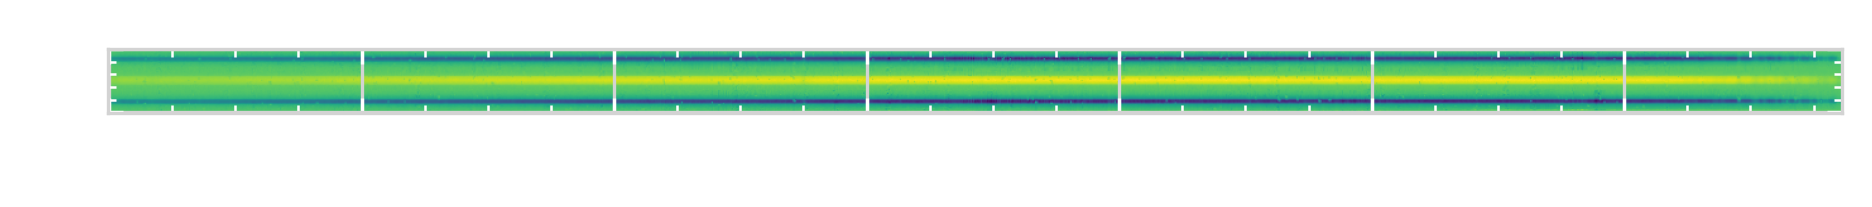

In [101]:
half = int(aper/2) # to make the cut out of the 2D image
plt.imshow(signal[ycen-half:ycen+half+1].copy())
plt.imshow(signal)

In [55]:

	# optimally-extracting 1D spectra
	half = int(aper/2) # to make the cut out of the 2D image
	spec = np.nansum(signal[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)
	err = np.nansum(error[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)
    
	# boxcar extract 1D spec
	row1, row2 = ycen-width, ycen+width # define the target aperture range
	specbox = np.sum(signal[row1:row2, :], axis=0)
	errbox = np.sum(error[row1:row2, :], axis=0)

In [51]:
signal[ycen-half:ycen+half+1].shape

(7, 1373)

In [62]:
# manually extract 1D spec

ypix = 64 ### change me to the ypixel you are extracting the spectrum from
wav, opt, opterr, box, boxerr = ex.extract1d(obj=obj_name,path=dir,ycen=ypix,aper=7,width=4) 


Reading in data for CAND_M44480
Dimensions: 	 signal spectrum (94, 1373)
		 error spectrum (94, 1373)


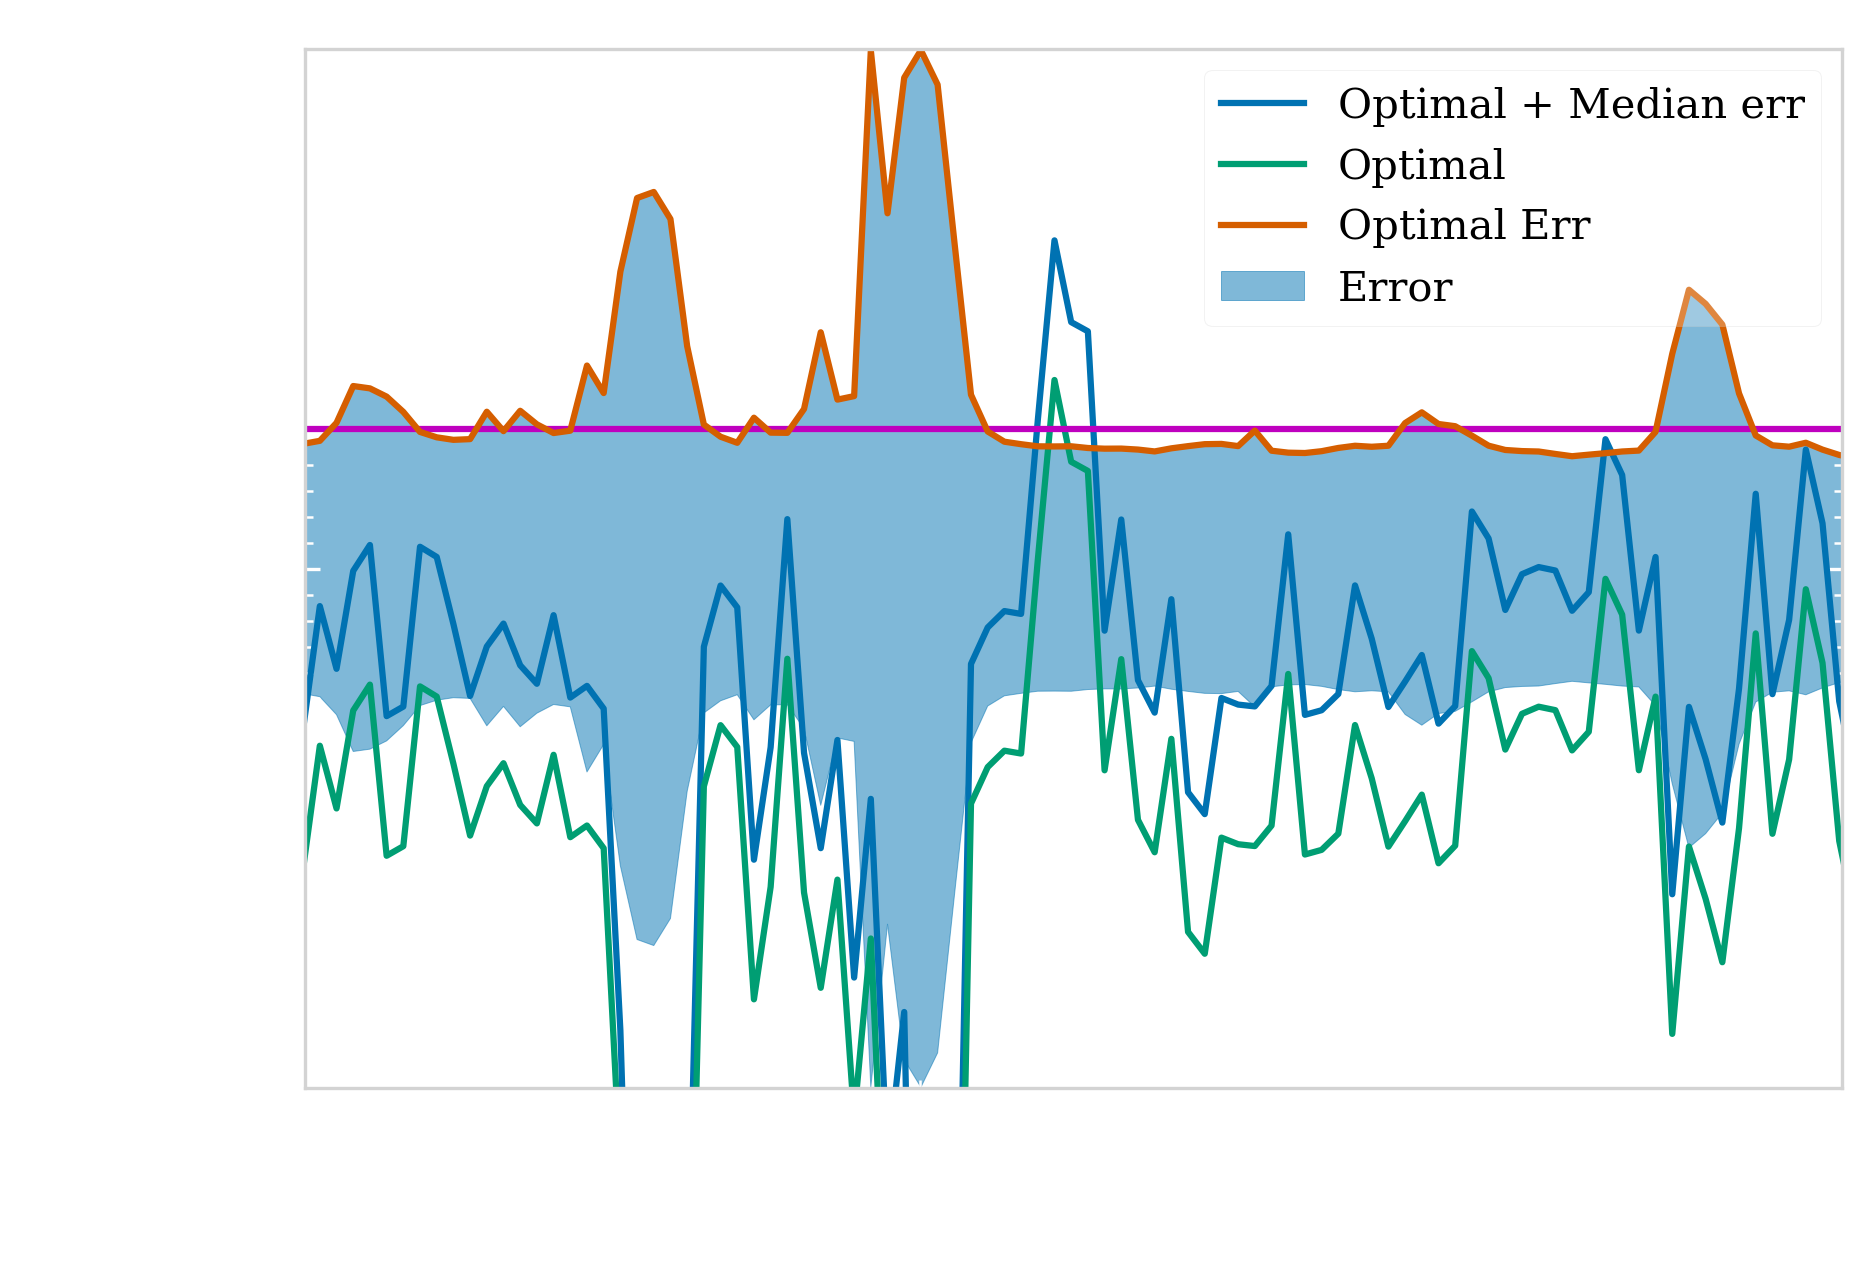

In [72]:
# plot optimal

plt.plot(wav,opt+np.median(opterr),label='Optimal + Median err')
plt.plot(wav,opt,label='Optimal')
plt.axhline(np.median(opterr),c='m')
plt.plot(wav,opterr,label='Optimal Err')
plt.fill_between(wav,opterr,-1*opterr,alpha=0.5,color='C0',label='Error')
plt.xlim(11050,11150) ### change me!
plt.ylim(-0.02,0.02) ### change me!
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux')
plt.grid(False)
plt.legend()

In [102]:
# get the a pixel coordinate near the image center (for later use)
ny, nx = signal.shape
cy, cx = ny//2, nx//2

# create 1d arays of the possible x and y values (for later use)
xs = np.arange(nx)
ys = np.arange(ny)

# pixel coordinates for each pixel (for later use)
yvals, xvals = np.indices(signal.shape)

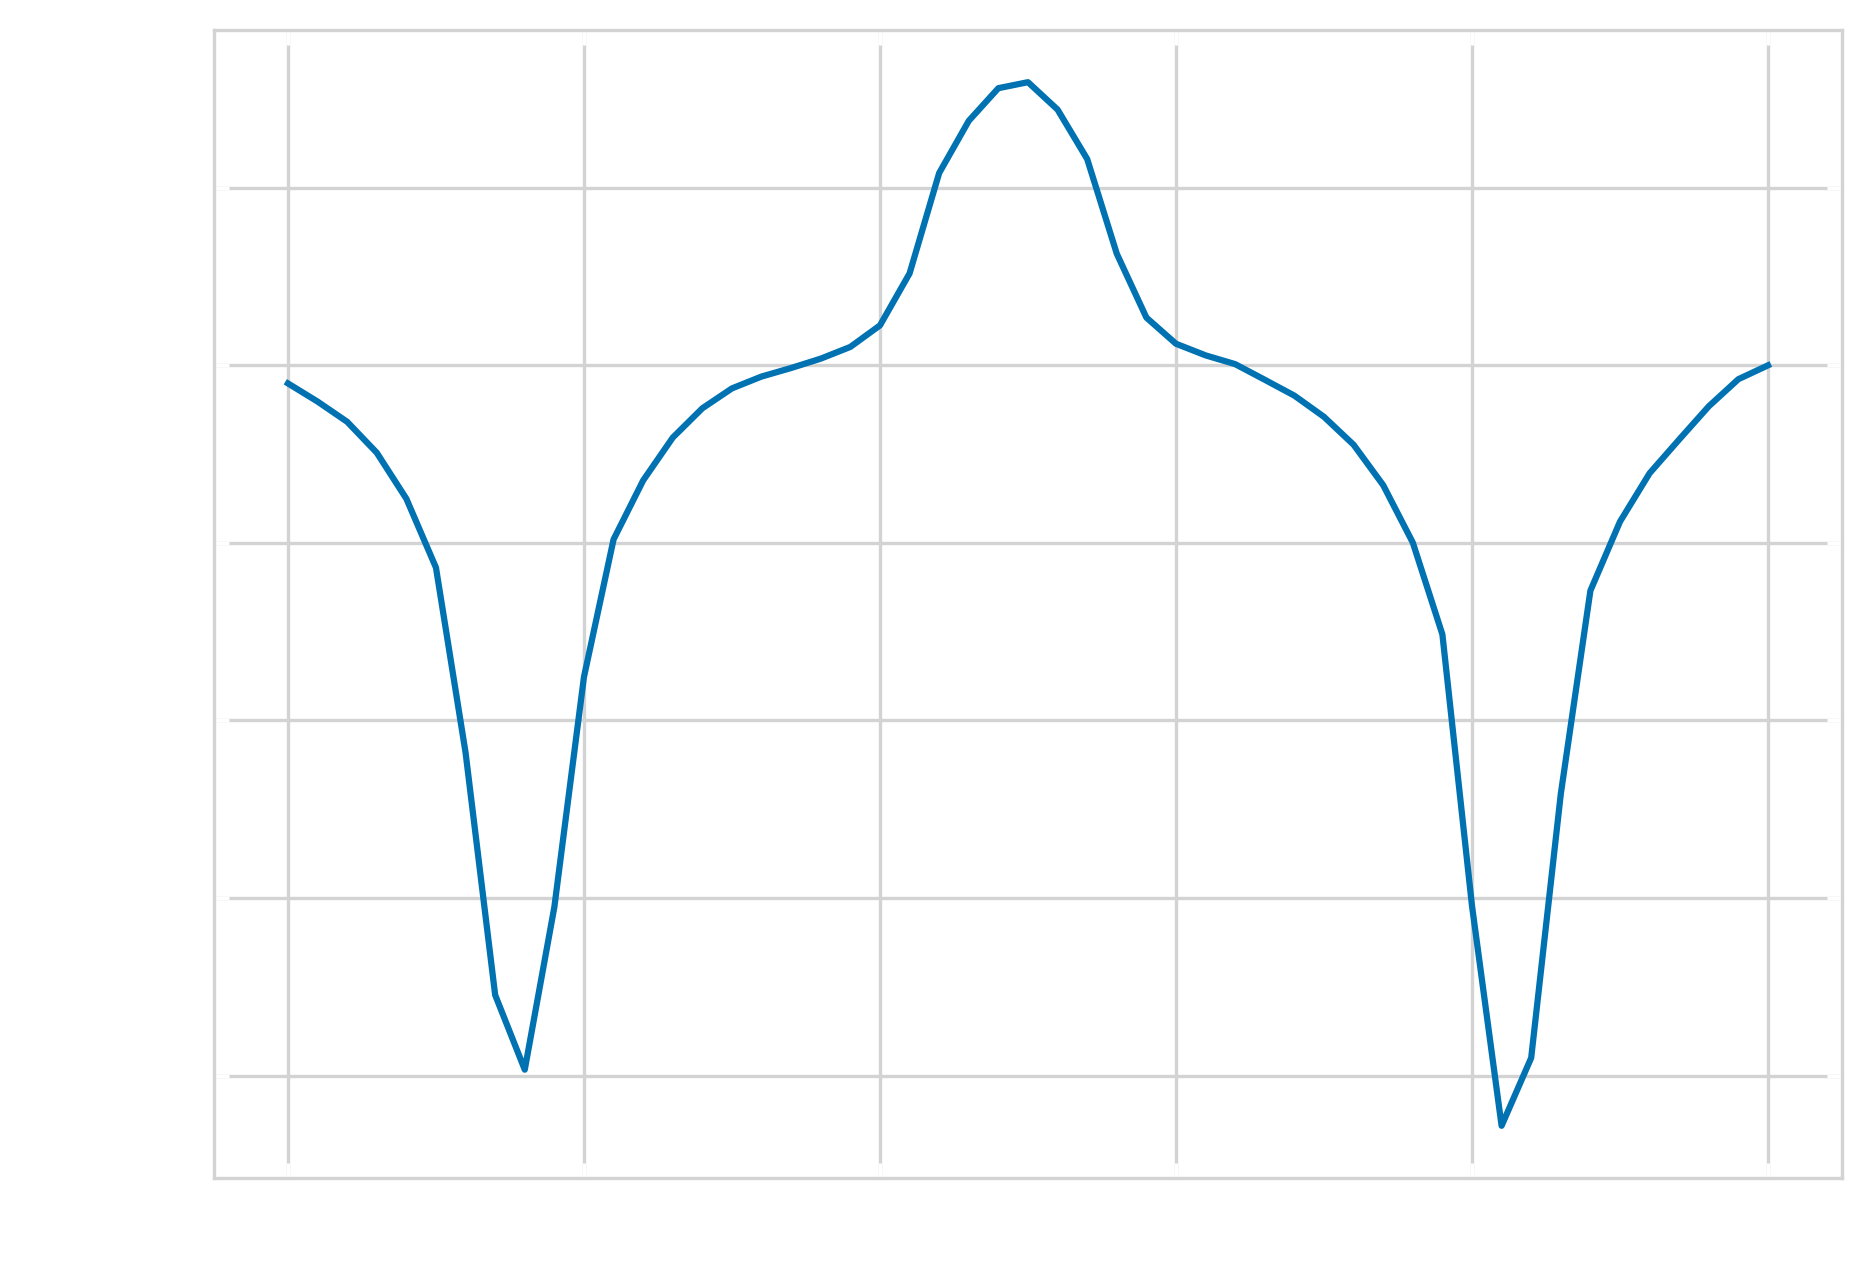

In [104]:
plt.plot(signal.sum(axis=1))

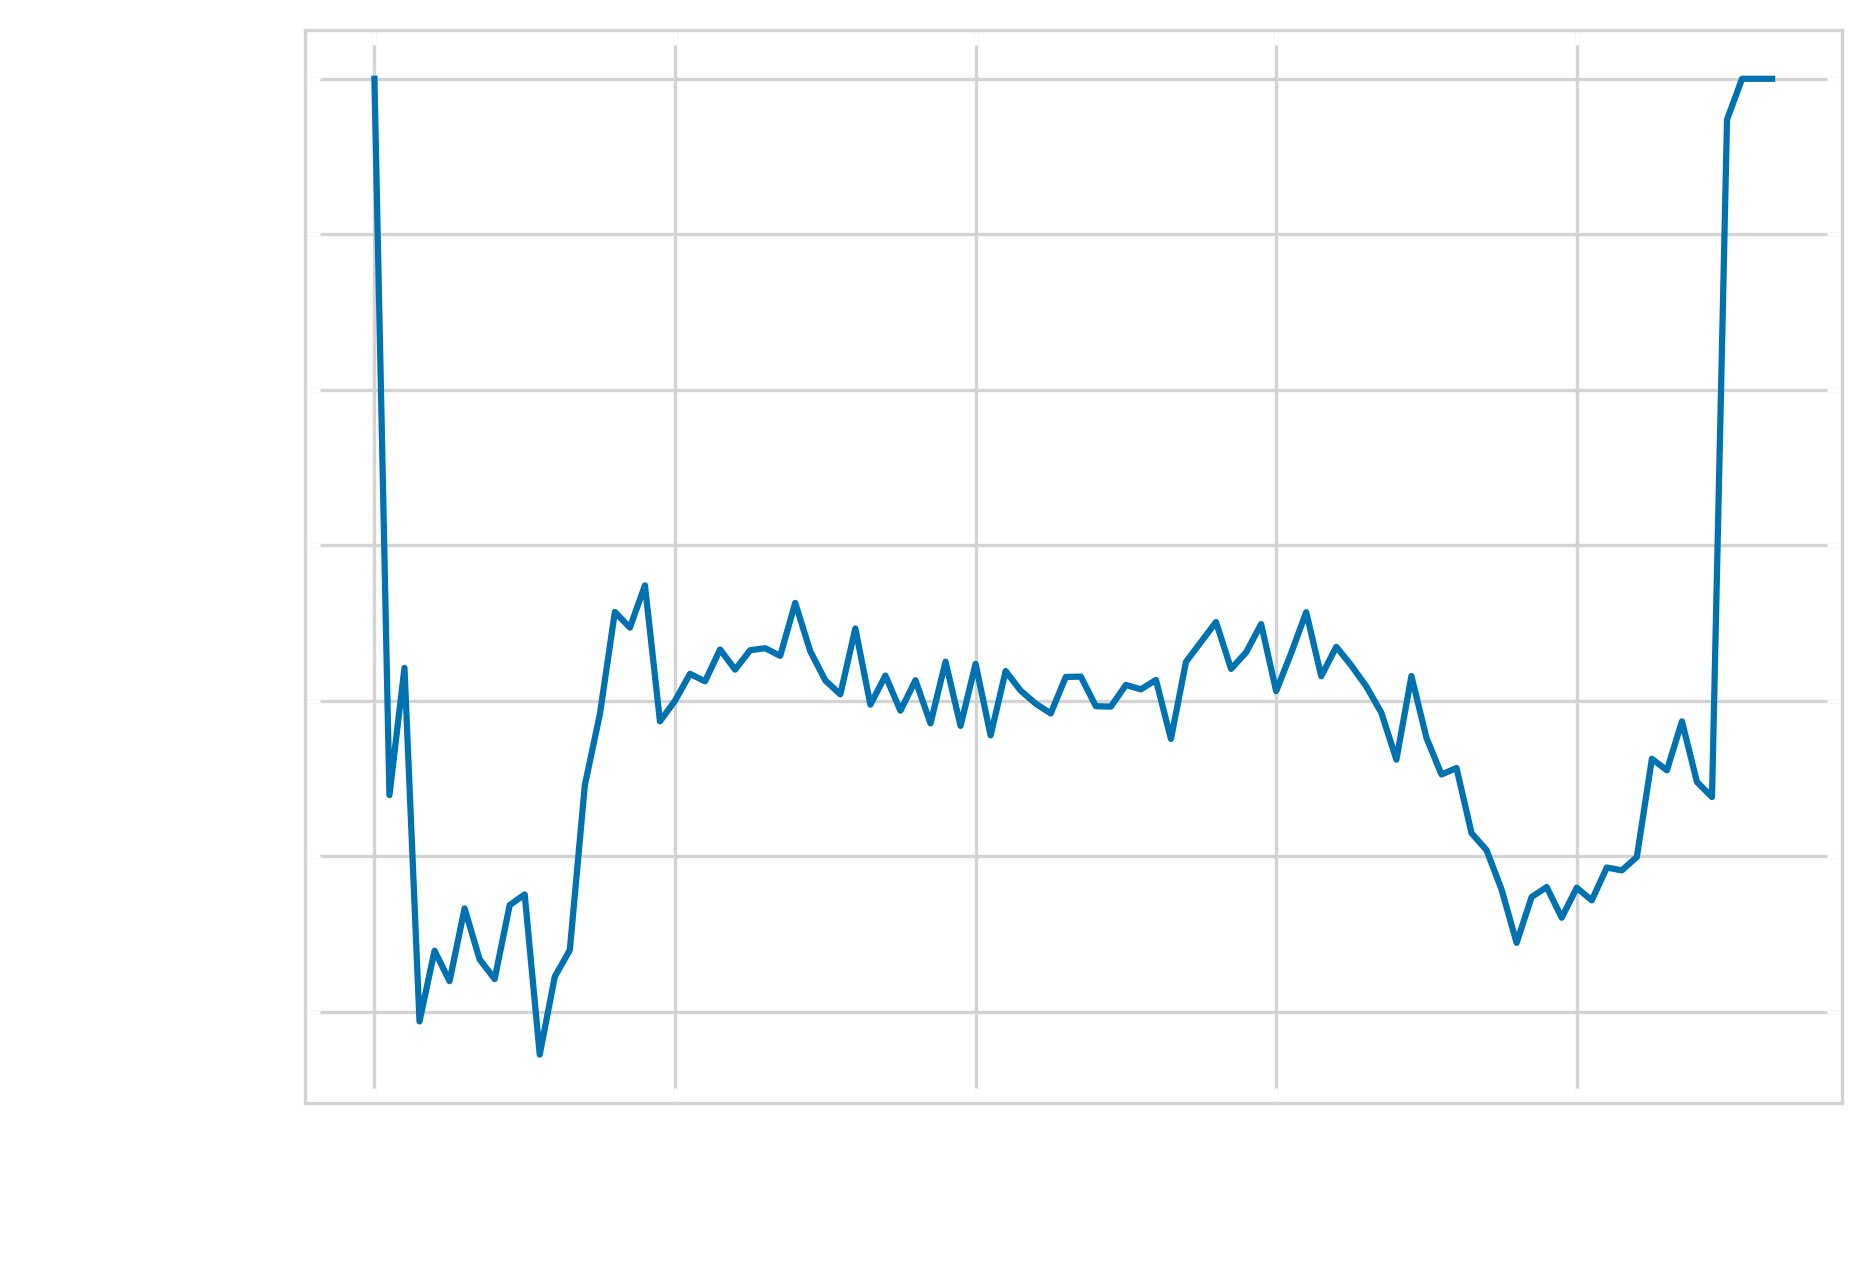

In [84]:
# calculate the weighted average (for each column)
spec_opt = signal[ycen-half:ycen+half+1].sum(axis=0) / signal.sum(axis=0)

# calculate the bias factor needed to scale the average to a sum
bias_factor = np.median(spec_basic / spec_opt)
spec_opt *= bias_factor

# same for the sky background
skybg_opt = (sky * profile_image)[ymin:ymax, :].sum(axis=0) / profile_image.sum(axis=0)
bias_factor_sky = np.median(skybg_basic / skybg_opt)
skybg_opt *= bias_factor_sky

# plot the extracted spectrum
plt.plot(xs, spec_basic, label='basic extraction')
plt.plot(xs, spec_opt, label='optimal extraction')
plt.xlabel('Column Number')
plt.ylabel('Counts');

In [58]:
import extract_1d_spec as exsp

In [129]:
obj_name = 'star_75'
notes = Table.read('cooper_full_notes.csv',format='csv')
idx = np.where(notes['obj']==obj_name)[0]
zguess = float(notes['zguess'][idx])
lguess = float(notes['wave'][idx])
ycen = int(notes['ypix_slit'][idx])
ddir = '../wmme01/mospy_products/wmme01_COMBINED_'
wav, pix, spec, _, err, rms = exsp.extract1d(obj_name, ddir, ycen)


Reading in data for M_W69492
Dimensions: 	 signal spectrum (90, 1373)
		 error spectrum (90, 1373)


(10250.0, 10350.0)

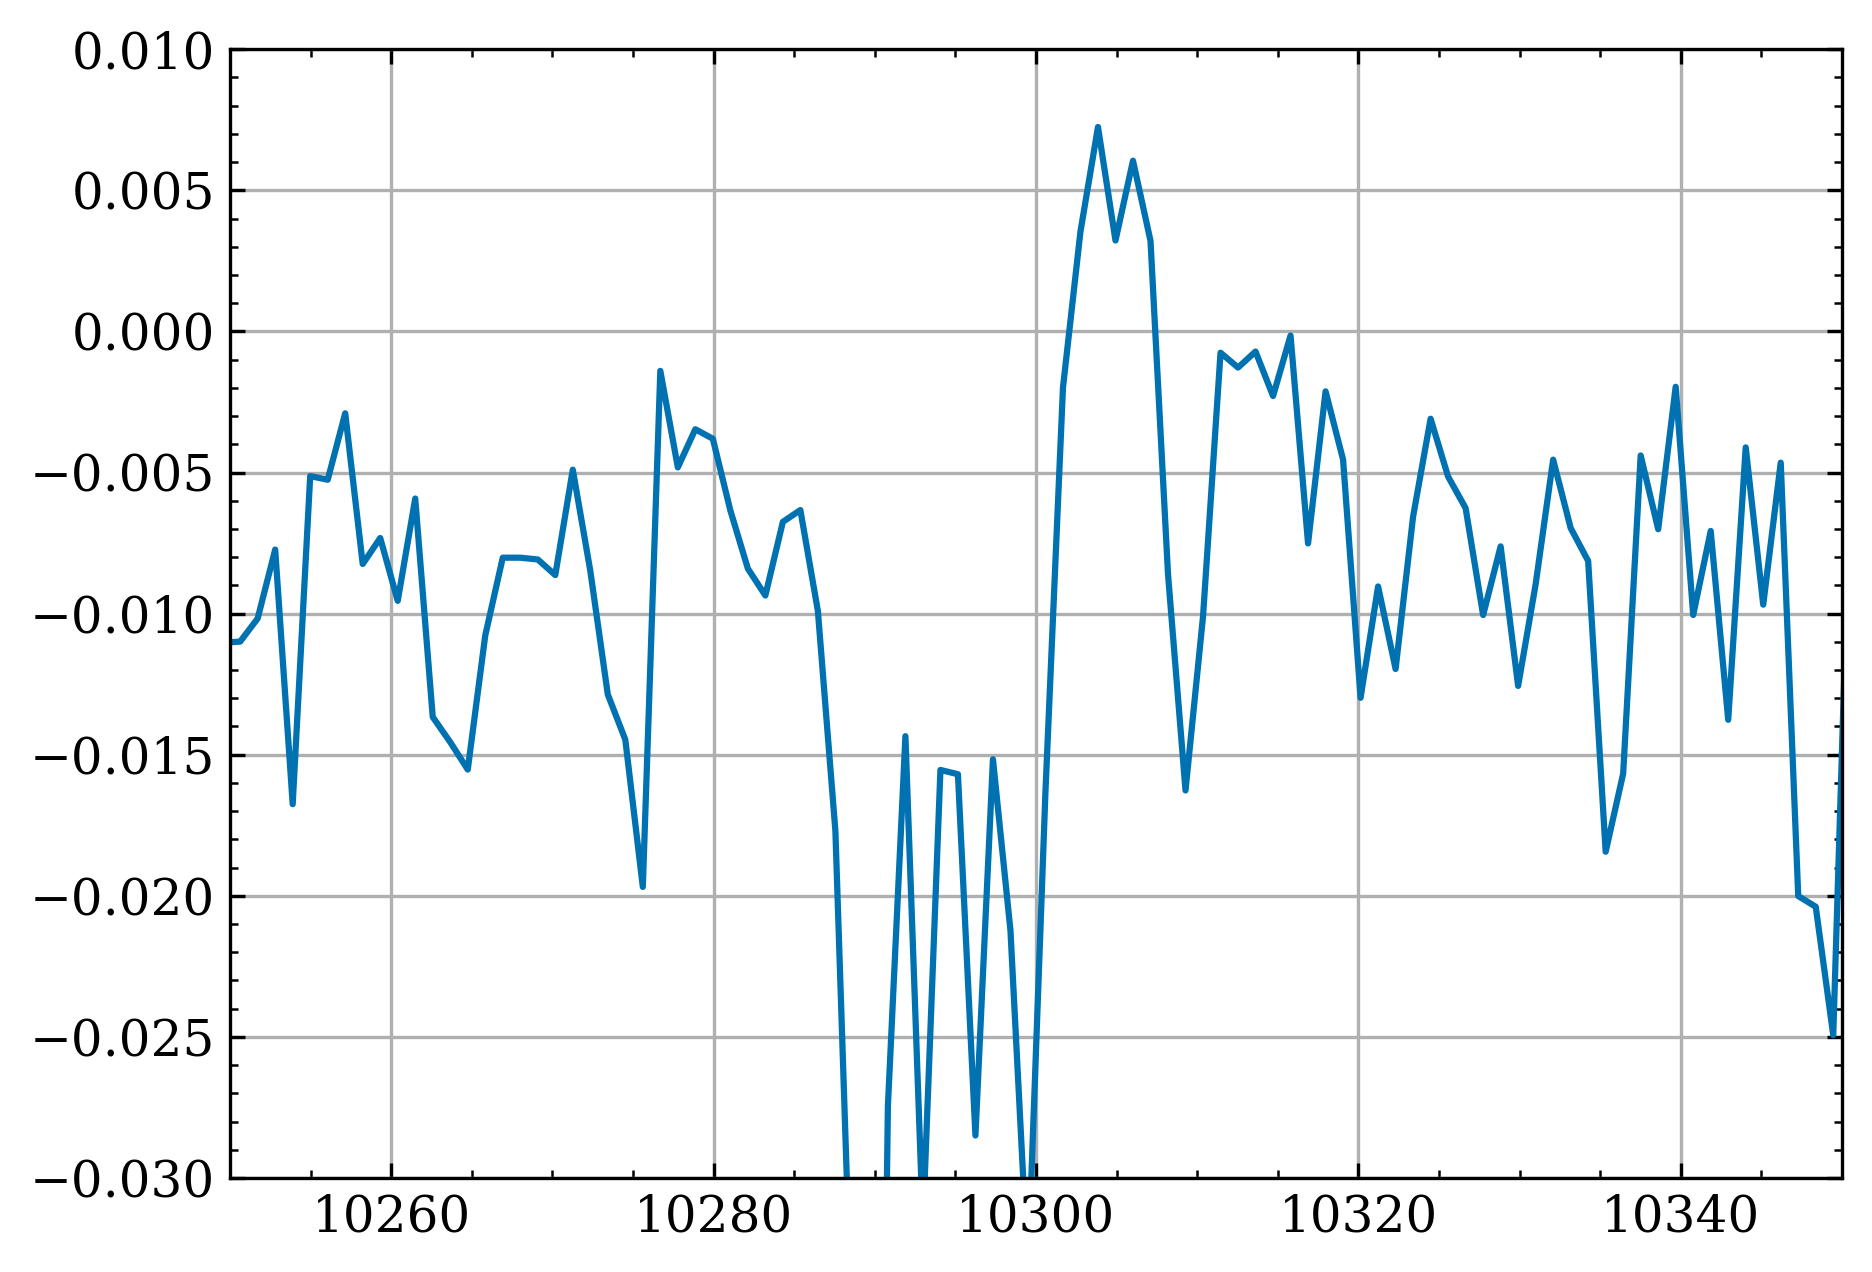

In [130]:
plt.plot(wav,spec)
plt.ylim(-0.03,0.01)
plt.xlim(10250,10350)

In [131]:
from astropy.stats import SigmaClip
from photutils.background import StdBackgroundRMS
obj=obj_name;path=ddir;ycen=31;aper=7;width=4

# reading in data
print(f'\nReading in data for {obj}')
header = fits.getheader(path + obj + '_eps.fits')
signal = fits.getdata(path + obj + '_eps.fits')
error = fits.getdata(path + obj + '_sig.fits')

print(f'Dimensions: \t signal spectrum {signal.shape}\n' +
        f'\t\t error spectrum {error.shape}')

# wavelength array
wavelength_start = header['CRVAL1'] # starting wavelength at first pixel
wavelength_logdisp = header['CD1_1'] # delta wavelength per pixel
num_wavelength = header['NAXIS1'] # length of data array
wave = wavelength_start + np.arange(0, wavelength_logdisp*num_wavelength, wavelength_logdisp) # wavelength

# pixel array
pix_start = header['CRPIX1'] # starting pixel
pix_logdisp = header['CD2_2'] # delta pixel per item
num_pix = header['NAXIS1'] # length of data array
pix = pix_start + np.arange(0, pix_logdisp*num_pix, pix_logdisp) # pixel

# defining optimized extraction gaussian
pixscale = header['PSCALE'] # arcsec/pix
fwhm = 0.8 / pixscale # arcsec / [arcsec/pixel]
gauss = gaussian(np.arange(aper),mean=3.,A=1.,sig=fwhm/2.35,offset=0.)
gauss /= sum(gauss) # to make it sum to 1 to use as weights
gauss_2D = np.zeros((len(gauss),len(wave))) # making 2D array of weights
for i in range(aper):
    gauss_2D[i] = gauss[i]

# optimally-extracting 1D spectra
half = int(aper/2) # to make the cut out of the 2D image
spec = np.nansum(signal[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)
erropt = np.nansum(error[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)

# find background rms
sigma_clip = SigmaClip(sigma=3.0) # define sigma clip
bkgrms = StdBackgroundRMS(sigma_clip) # define background rms
bkgrms_value = bkgrms.calc_background_rms(signal,axis=0) # create background rms array
sky_idx = np.where(np.logical_and((bkgrms_value > np.nanmean(bkgrms_value)) == False, bkgrms_value > 0))[0] # find nonzero and non-skyline indices
bkg = bkgrms_value.copy() # make copy of background array to do stuff on
z3 = np.polyfit(wave[sky_idx],bkg[sky_idx],deg=3) # fit 3rd degree polynomial to wavelength and nonzero non-sky background
fit3 = np.poly1d(z3) # function to evaluate the polynomial fit
rms = fit3(wave) # evaluate the best fit function at the full wavelength array

# boxcar extract 1D spec
row1, row2 = ycen-width, ycen+width # define the target aperture range
specbox = np.sum(signal[row1:row2, :], axis=0)
errbox = np.sum(error[row1:row2, :], axis=0)

# sky spectrum from mospy
err = np.nanmedian(error, axis=0)


Reading in data for M_W69492
Dimensions: 	 signal spectrum (90, 1373)
		 error spectrum (90, 1373)


little d to source, big D to source
little n nod amp
y of source (fraction)
n+d/(2n+D)

In [132]:
gauss_2D.shape

(7, 1373)

In [133]:
signal[ycen-half:ycen+half+1].copy().shape

(7, 1373)

In [34]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 24 17:26:42 2022

Plot spectra from pypeit products

@author: 0cooper
"""

# the basics

import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clip
from scipy.signal import find_peaks
import read_mospy_files as rmp 
import glob
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from scipy.ndimage import gaussian_filter1d
plt.style.use('../cooper-paper.mplstyle')

# select object
obj_name = 'M_W69492'
notes = Table.read('cooper_full_notes.csv',format='csv')
idx = np.where(notes['obj']==obj_name)[0]
zguess = float(notes['zguess'][idx])
lguess = float(notes['wave'][idx])
print('working on object',obj_name,'with zguess = ',zguess,'at lambda = ',lguess,'AA')

if notes['mask'][idx] == 'wmmc01':
    ddir = '../wmmc01/'
elif notes['mask'][idx] == 'wmmc02':
    ddir = '../wmmc02/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmmc03':
    ddir = '../wmmc03/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmmc05':
    ddir = '../wmmc05/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmmc06':
    ddir = '../wmmc06/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmmu01':
    ddir = '../wmmu01/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmme01':
    ddir = '../wmme01/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmme02':
    ddir = '../wmme02/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmme03':
    ddir = '../wmme03/pypeit_products/Science_coadd_1x1/'
        
### add the other masks

working on object M_W69492 with zguess =  7.4775 at lambda =  10304.0 AA


In [45]:
# open 1D and 2D spectrum for an object
tab1 = Table.read(ddir+obj_name+'_1dspec.txt',format='ascii') # created 1d spec txt file from read_pypeit_files.py
file = glob.glob(ddir+'spec2d*.fits')[0] # 2d pypeit image
hdu2 = fits.open(file) # open image
pid = int(notes['pypeit_ref_idx'][idx])-1 # pypeit id to identify the slit
header = hdu2[0].header # header info
signal = hdu2[1].data # signal image data

ref = hdu2[10].data[pid] # reference to slit in 2d image
print('check this is the right source:',ref)
x1 = ref[4][0] # left side of slit
x2 = ref[5][0] # right side of slit
xcen = ref[2] # object
sig2d = signal[0:,int(x1):int(x2)].T # signal for the slit (transposed)

check this is the right source: (2289, 6, 41.0, array([50., 50., 50., ..., 50., 50., 50.]), array([2239., 2239., 2239., ..., 2239., 2239., 2239.]), array([2339., 2339., 2339., ..., 2339., 2339., 2339.]), array([2289., 2289., 2289., ..., 2289., 2289., 2289.]), 0, 0, 0.0, 2047.0)


In [13]:
plt.plot(wave[0:,xcen],spec,'k')

NameError: name 'wave' is not defined

candidate line at  10304.0 AA;  1043 pix
detected at  2.49  sigma


(-7.536516095426446, 15.073032190852892)

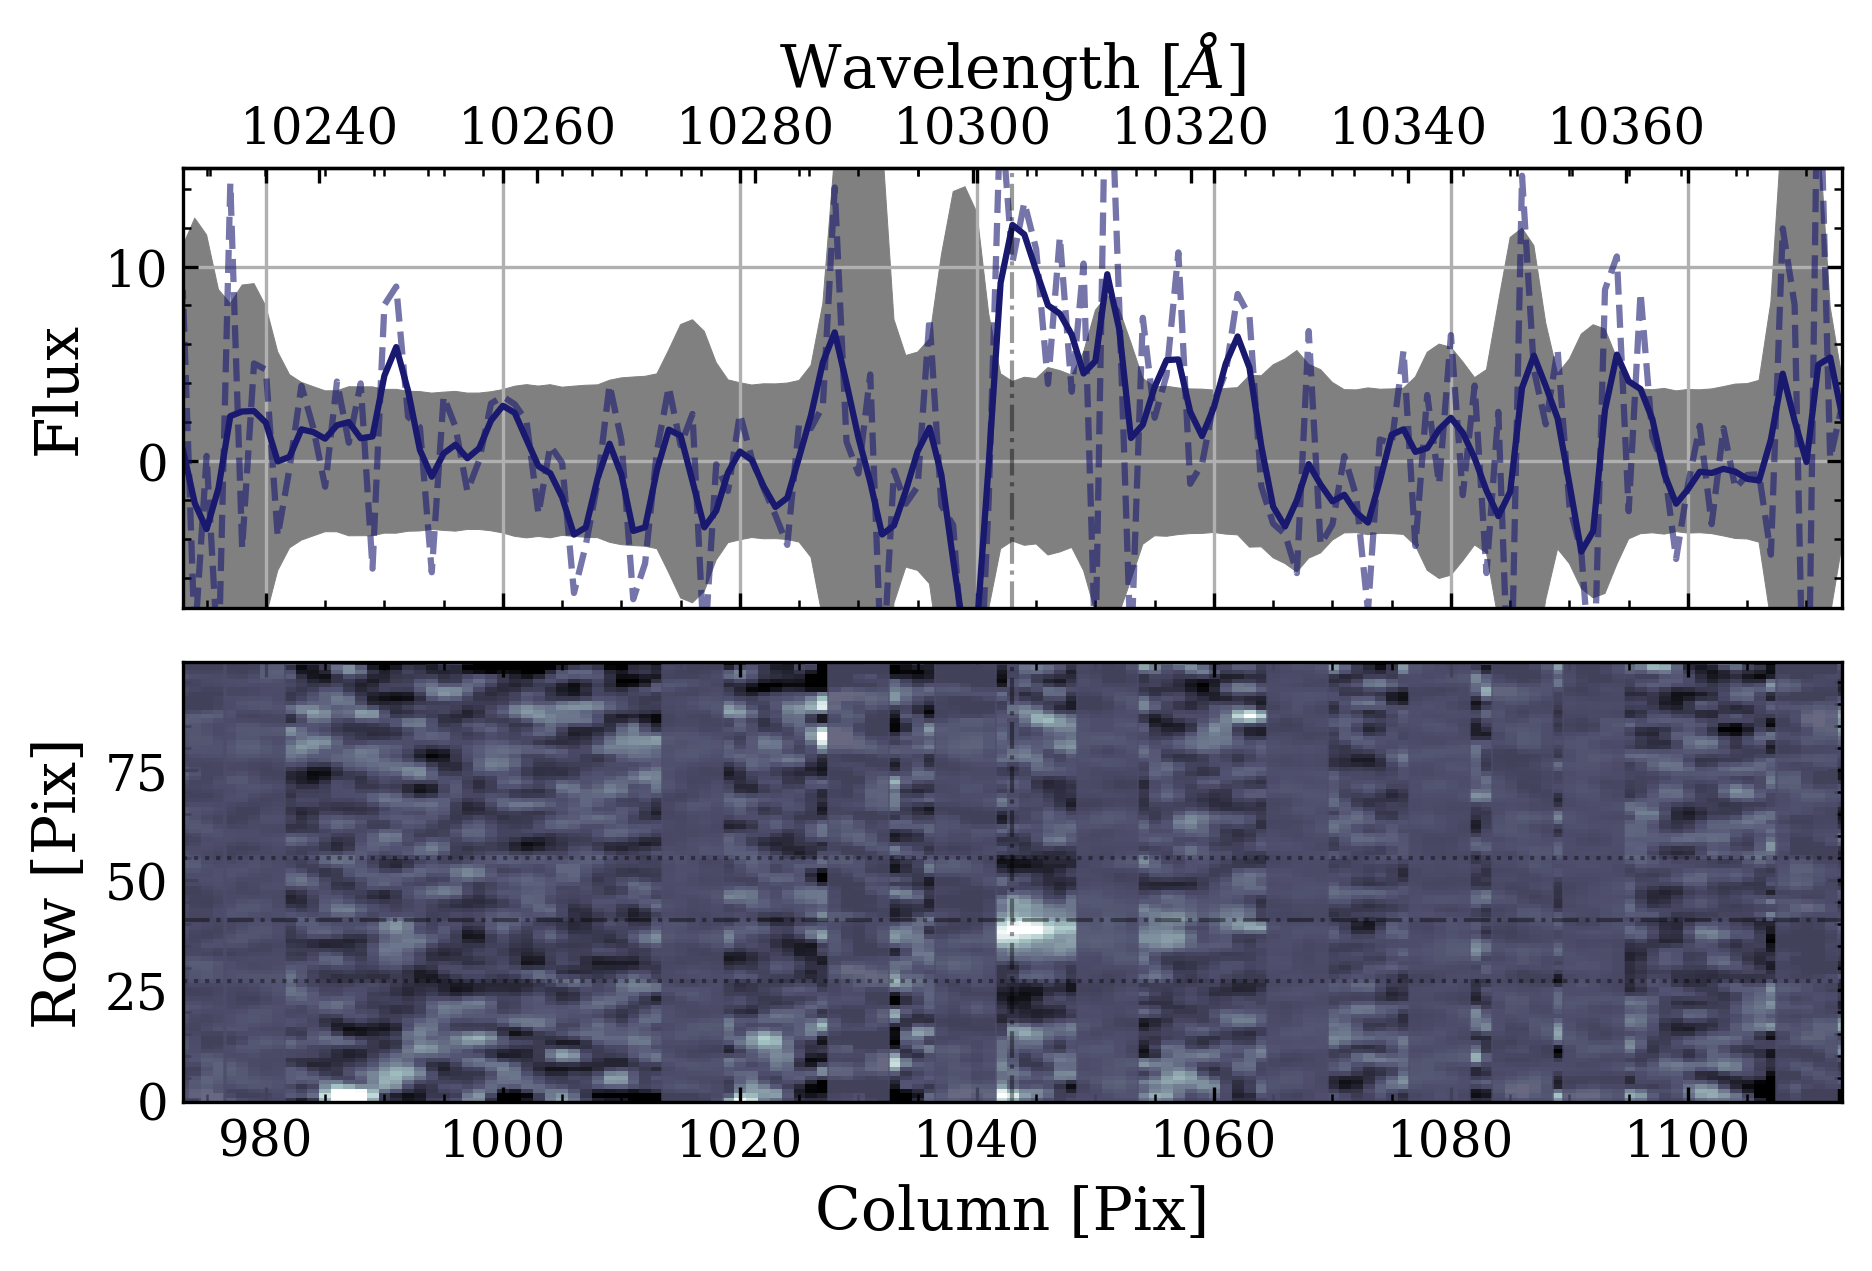

In [47]:
pixscale = hdu2[0].header['PSCALE'] # arcsec/pix
slitwidth = 2.5 # arcsec
nodamp = slitwidth/pixscale # nod amplitude in pixels

# gaussian smooth 2D spec
kernel = Gaussian2DKernel(x_stddev=1.)
conv_im = convolve(sig2d, kernel)

### START FIG!
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

# 1D spec
ax1.plot(tab1['pix'],gaussian_filter1d(tab1['opt_counts'],sigma=1),c='MidnightBlue',label=obj_name)
ax1.plot(tab1['pix'],tab1['opt_counts'],c='MidnightBlue',ls='--',alpha=0.6) 
ax1.fill_between(tab1['pix'], y1=tab1['opt_sigma'], y2=-1*tab1['opt_sigma'], color='gray', label='sky')
ax1.set_ylabel(r'Flux')

# 2D spec
lower=-1; upper=2
sample = sigma_clip(sig2d) 
vmin = sample.mean() + lower * sample.std()
vmax = sample.mean() + upper * sample.std()
ax2.imshow(conv_im, origin='lower', cmap='bone', aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_xlabel('Column [Pix]')
ax2.set_ylabel('Row [Pix]')
ax2.grid(False)

# block out sky lines 2D
ipk = find_peaks(tab1['opt_sigma'], height=np.mean(tab1['opt_sigma']))[0]
for i in ipk:
    ax2.axvline(tab1['pix'][i],c='#4D4D6B',lw=15,alpha=0.85)

    
# secax = secondary axis for wavelength space
def forward(x):
    return np.interp(x, tab1['pix'], tab1['lambda'])

def inverse(x):
    return np.interp(x, tab1['lambda'], tab1['pix'])

secax = ax1.secondary_xaxis('top', functions=(forward, inverse))
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel(r'Wavelength [$\AA$]')

# mark measured line at pixel guess based on lambda guess
pguess = tab1['pix'][rmp.closest(tab1['lambda'],lguess)[0]] # pixel closest to wavelength of line to center on
s = tab1['opt_counts'][rmp.closest(tab1['lambda'],lguess)[0]] # signal closest to wavelength of line
n = tab1['opt_sigma'][rmp.closest(tab1['lambda'],lguess)[0]] # error closest to wavelength of line
sn = np.round(s/n,2)
print("candidate line at ",lguess,'AA; ',pguess,'pix')
print("detected at ",sn,' sigma')
ax1.axvline(pguess,lw=1,c='k',ls='-.',alpha=0.4)
ax2.axvline(pguess,lw=1,c='k',ls='-.',alpha=0.4)
ax2.axhline(xcen,lw=1,c='k',ls='-.',alpha=0.4)
ax2.axhline(xcen+nodamp,lw=1,c='k',ls=':',alpha=0.4)
ax2.axhline(xcen-nodamp,lw=1,c='k',ls=':',alpha=0.4)


ax1.set_xlim(pguess-70,pguess+70)
ax2.set_xlim(pguess-70,pguess+70)
ax1.set_ylim(-2*np.nanmedian(tab1['opt_sigma']),4*np.nanmedian(tab1['opt_sigma']))

#plt.show()
#plt.savefig('/Users/oc4858/Library/CloudStorage/Box-Box/werls/plots/'+obj_name+'_pypeit_1D_2D.png',dpi=500)


In [76]:
"""
Plot spectra from mospy products

added:
match pix/wavelength
mark lines
filled in sky lines 1d
blocked out sky lines 2d
gaussian smooth 2d
manual extract 1d

need to do:
mark slit pos in y axis


@author: 0cooper

"""

# the basics

import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clip
from scipy.signal import find_peaks
import read_mospy_files as rmp 
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from scipy.ndimage import gaussian_filter1d
import extract_1d_spec as exsp 
plt.style.use('../cooper-presentation.mplstyle')

# select object
obj_name = 'M_W69492'
notes = Table.read('cooper_full_notes.csv',format='csv')
idx = np.where(notes['obj']==obj_name)[0]
zguess = float(notes['zguess'][idx])
lguess = float(notes['wave'][idx])
ycen = int(notes['ypix_slit'][idx])
print('working on object',obj_name,'with zguess = ',zguess,'at lambda = ',lguess,'AA and mospy ypix = ',ycen)

if notes['mask'][idx] == 'wmmc01':
    ddir = '../wmmc01/wmmc01_Y_'
elif notes['mask'][idx] == 'wmmc02':
    ddir = '../wmmc02/mospy_products/COMBINED/wmmc02_COMBINED_'
elif notes['mask'][idx] == 'wmmc03':
    ddir = '../wmmc03/mospy_products/COMBINED/wmmc03b_COMBINED_'
elif notes['mask'][idx] == 'wmmc05':
    ddir = '../wmmc05/mospy_products/COMBINED/wmmc05b_COMBINED_'
elif notes['mask'][idx] == 'wmmc06':
    ddir = '../wmmc06/mospy_products/wmmc06b_Y_'
elif notes['mask'][idx] == 'wmmu01':
    ddir = '../wmmu01/mospy_products/wmmu01_COMBINED_'
elif notes['mask'][idx] == 'wmme01':
    ddir = '../wmme01/mospy_products/wmme01_COMBINED_'
elif notes['mask'][idx] == 'wmme02':
    ddir = '../wmme02/mospy_products/wmme02b_Y_'
elif notes['mask'][idx] == 'wmme03':
    ddir = '../wmme03/mospy_products/wmme03_Y_'
    

# open 1D and 2D spectrum for an object
hdu2 = fits.open(ddir+obj_name+'_eps.fits') # mospy 2D spectrum file
signal = hdu2[0].data # 2D spectrum array

working on object M_W69492 with zguess =  7.4775 at lambda =  10304.0 AA and mospy ypix =  31


In [30]:
signal.shape

(90, 1373)

In [65]:
90*0.41

36.9

In [54]:
targra = hdu2[0].header['TARGRA']
targd = hdu2[0].header['TARGDEC']

In [56]:
targra,targd

(215.04354167, 52.97468889)

In [57]:
215.05063,53.00796

(215.05063, 53.00796)

In [66]:
exsp.extract1d?


Reading in data for M_W69492
Dimensions: 	 signal spectrum (90, 1373)
		 error spectrum (90, 1373)
candidate line at  10304.0 AA;  511 pix
detected at  3.13  sigma


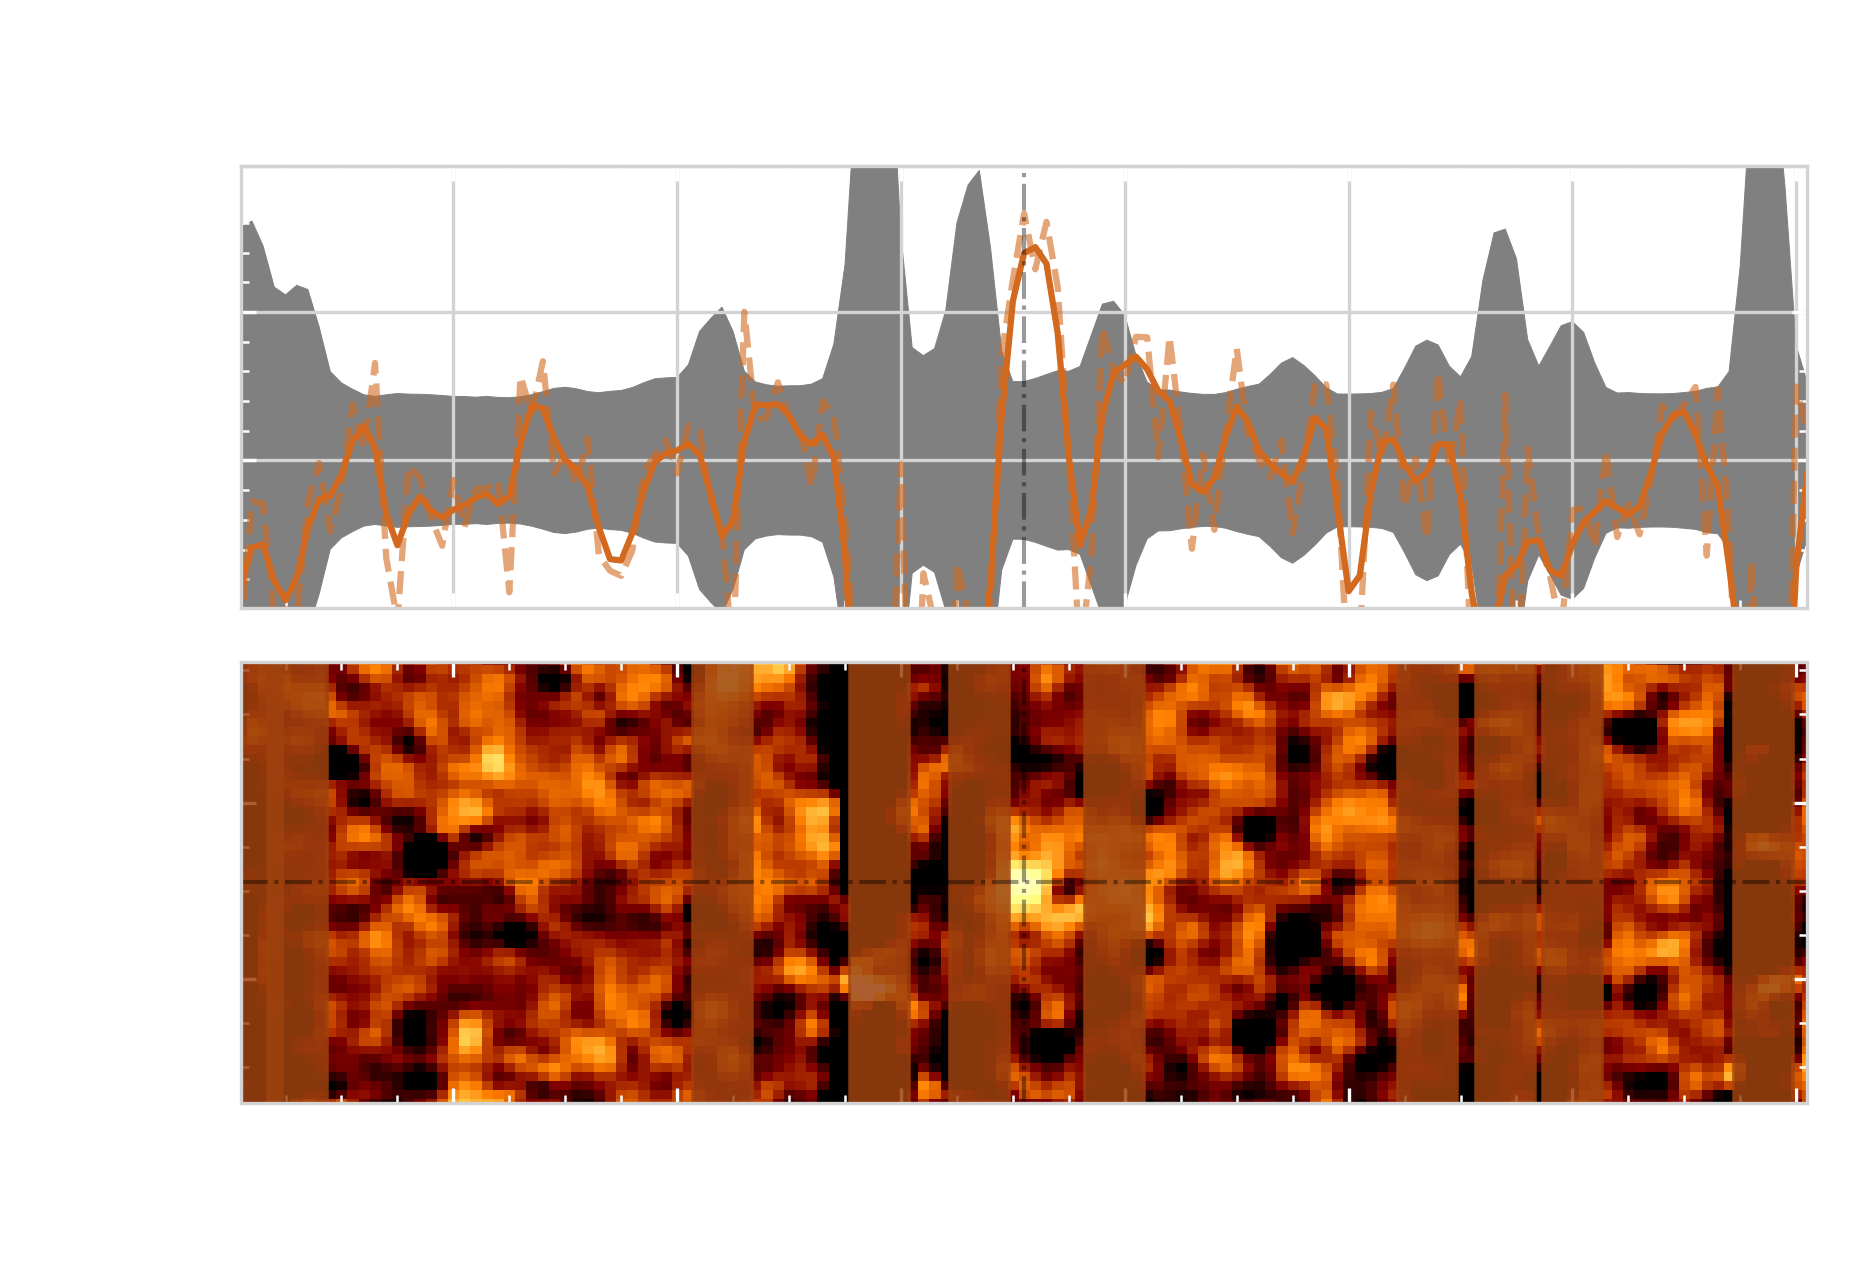

In [7]:


if len(sys.argv) == 2:
    # don't include the rms addition to spectrum
    wav, pix, spec, _, err, _ = exsp.extract1d(obj_name, ddir, ycen, FWHM = 0.456) # optimally extract 1D spectrum
    rms = np.zeros_like(wav)
else:
    # include rms addition to spectrum to fix oversubtraction
    wav, pix, spec, _, err, rms = exsp.extract1d(obj_name, ddir, ycen, FWHM = 0.456) # optimally extract 1D spectrum

pixscale = hdu2[0].header['PSCALE'] # arcsec/pix
slitwidth = 2.5 # arcsec
nodamp = slitwidth/pixscale # nod amplitude in pixels

# gaussian smooth 2D spec
kernel = Gaussian2DKernel(x_stddev=1)
conv_im = convolve(hdu2[0].data, kernel)

### START FIG!
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

# 1D spec
ax1.plot(pix,gaussian_filter1d(spec+rms,sigma=1),c='chocolate',label=obj_name)
ax1.plot(pix,spec+rms,c='chocolate',ls='--',alpha=0.6) 
ax1.fill_between(pix, y1=err, y2=-1*err, color='gray', label='sky')
ax1.set_ylabel(r'Flux')

# 2D spec
lower=-1; upper=2
sample = sigma_clip(hdu2[0].data) 
vmin = sample.mean() + lower * sample.std()
vmax = sample.mean() + upper * sample.std()
ax2.imshow(conv_im, origin='lower', cmap='afmhot', aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_xlabel('Column [Pix]')
ax2.set_ylabel('Row [Pix]')
ax2.grid(False)

# block out sky lines 2D
ipk = find_peaks(err, height=np.mean(err))[0]
for i in ipk:
    ax2.axvline(pix[i],c='#9E420E',lw=15,alpha=0.85)

    
# secax = secondary axis for wavelength space
def forward(x):
    return np.interp(x, pix, wav)

def inverse(x):
    return np.interp(x, wav, pix)

secax = ax1.secondary_xaxis('top', functions=(forward, inverse))
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel(r'Wavelength [$\AA$]')

# mark measured line at pixel guess based on lambda guess
pguess = pix[rmp.closest(wav,lguess)[0]] # pixel closest to wavelength of line to center on
print("candidate line at ",lguess,'AA; ',pguess,'pix')
s = (spec+rms)[rmp.closest(wav,lguess)[0]] # signal closest to wavelength of line
n = err[rmp.closest(wav,lguess)[0]] # error closest to wavelength of line
sn = np.round(s/n,2)
print("detected at ",sn,' sigma')
ax1.axvline(pguess,lw=1,c='k',ls='-.',alpha=0.4)
ax2.axvline(pguess,lw=1,c='k',ls='-.',alpha=0.4)

# mark obj position on slit and nods
ax2.axhline(ycen,lw=1,c='k',ls='-.',alpha=0.4)


# limits
ymin = [ycen-25 if (ycen > 25)==True else 0][0]
ymax = [ycen+25 if (len(conv_im) > ycen+25)==True else len(conv_im)-1][0]
ax1.set_xlim(pguess-70,pguess+70)
ax1.set_ylim(-2*np.nanmedian(err),4*np.nanmedian(err))
ax2.set_xlim(pguess-70,pguess+70)
ax2.set_ylim(ymin,ymax) 

plt.show()
# save fig
#plt.savefig('/Users/oc4858/Library/CloudStorage/Box-Box/werls/plots/'+obj_name+'_mospy_1D_2D.png',dpi=500)



Reading in data for M_W69492
Dimensions: 	 signal spectrum (90, 1373)
		 error spectrum (90, 1373)
candidate line at  10304.0 AA;  511 pix
detected at  2.85  sigma


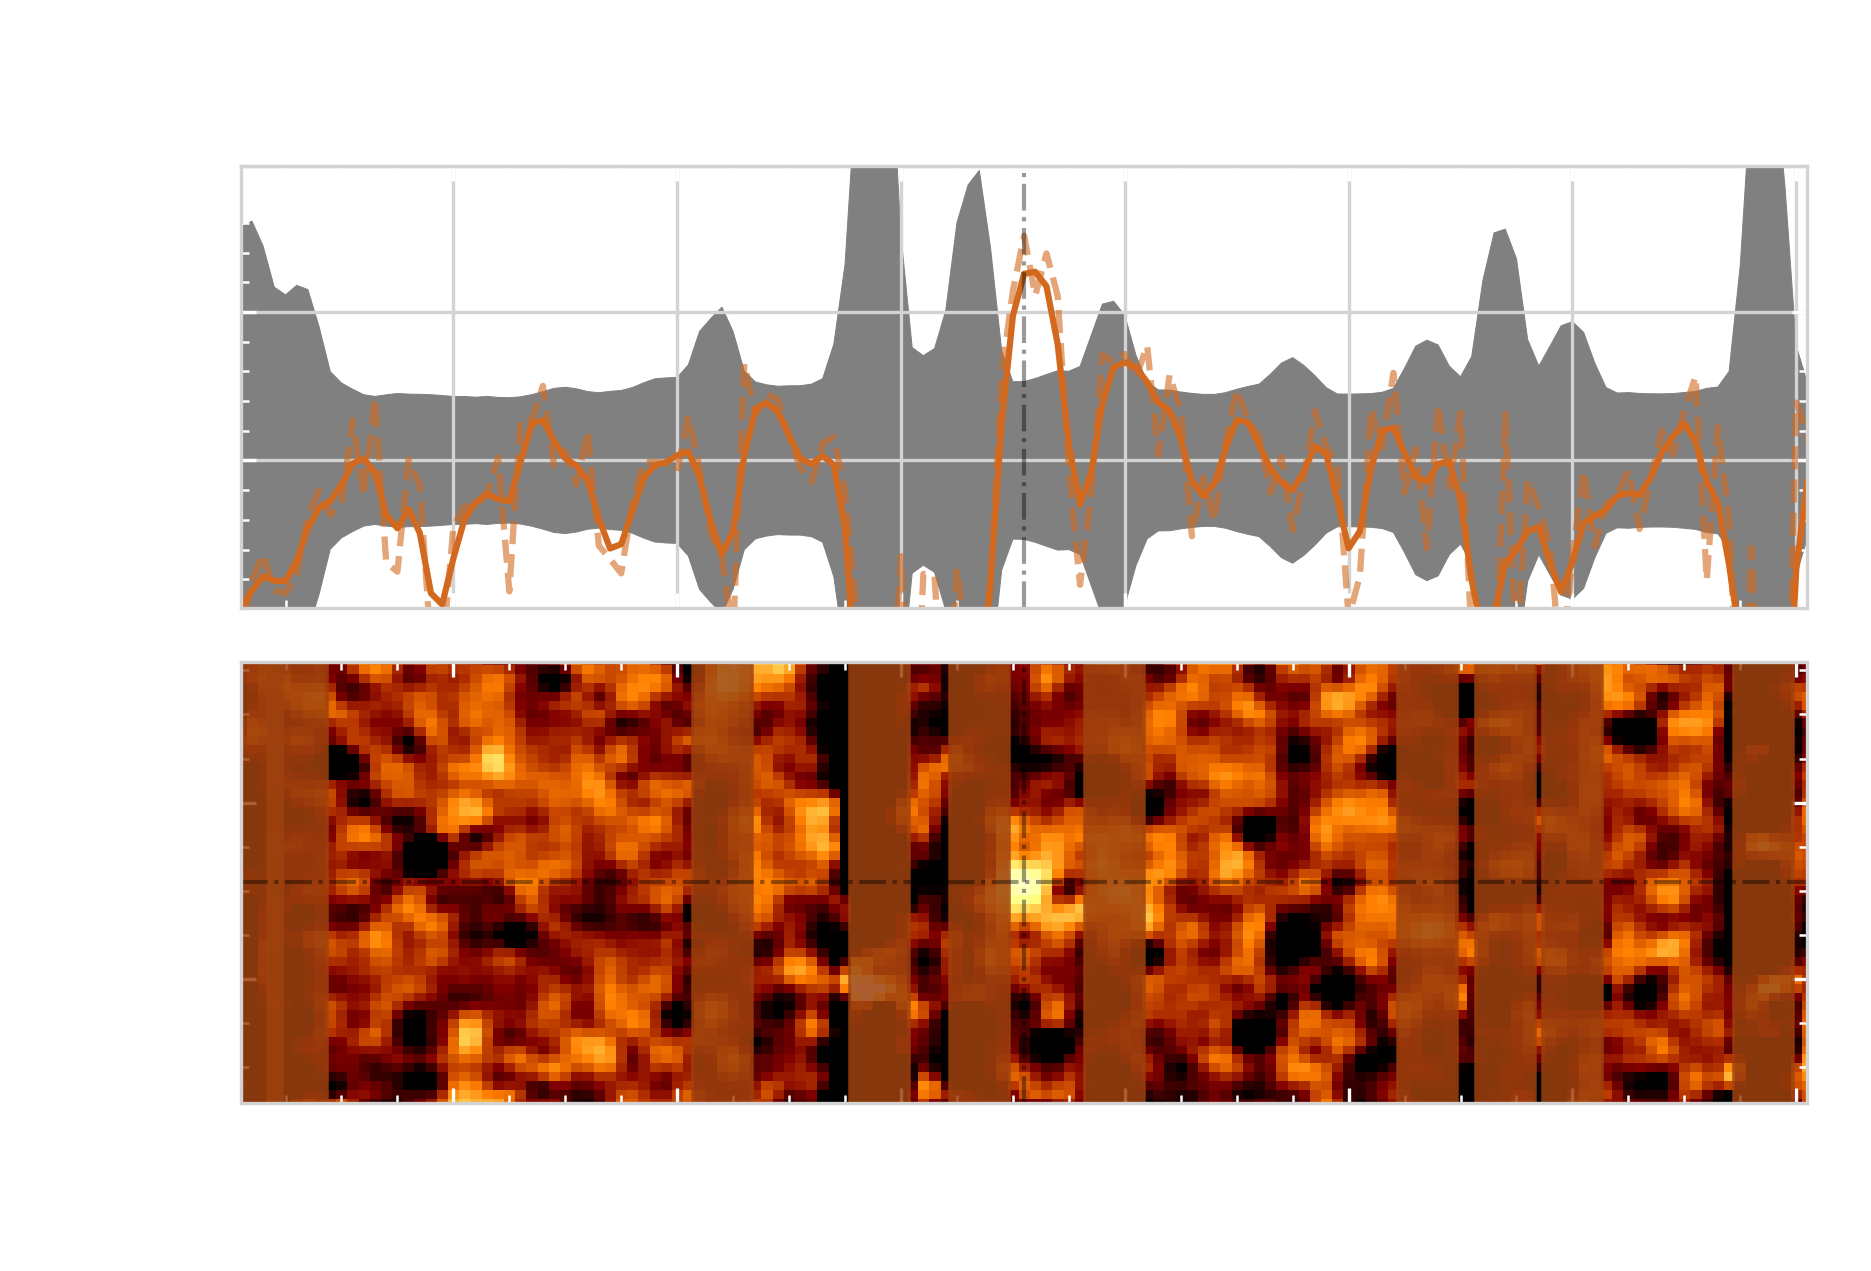

In [3]:


if len(sys.argv) == 2:
    # don't include the rms addition to spectrum
    wav, pix, spec, _, err, _ = exsp.extract1d(obj_name, ddir, ycen, FWHM = 0.8) # optimally extract 1D spectrum
    rms = np.zeros_like(wav)
else:
    # include rms addition to spectrum to fix oversubtraction
    wav, pix, spec, _, err, rms = exsp.extract1d(obj_name, ddir, ycen, FWHM = 0.8) # optimally extract 1D spectrum

pixscale = hdu2[0].header['PSCALE'] # arcsec/pix
slitwidth = 2.5 # arcsec
nodamp = slitwidth/pixscale # nod amplitude in pixels

# gaussian smooth 2D spec
kernel = Gaussian2DKernel(x_stddev=1)
conv_im = convolve(hdu2[0].data, kernel)

### START FIG!
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

# 1D spec
ax1.plot(pix,gaussian_filter1d(spec+rms,sigma=1),c='chocolate',label=obj_name)
ax1.plot(pix,spec+rms,c='chocolate',ls='--',alpha=0.6) 
ax1.fill_between(pix, y1=err, y2=-1*err, color='gray', label='sky')
ax1.set_ylabel(r'Flux')

# 2D spec
lower=-1; upper=2
sample = sigma_clip(hdu2[0].data) 
vmin = sample.mean() + lower * sample.std()
vmax = sample.mean() + upper * sample.std()
ax2.imshow(conv_im, origin='lower', cmap='afmhot', aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_xlabel('Column [Pix]')
ax2.set_ylabel('Row [Pix]')
ax2.grid(False)

# block out sky lines 2D
ipk = find_peaks(err, height=np.mean(err))[0]
for i in ipk:
    ax2.axvline(pix[i],c='#9E420E',lw=15,alpha=0.85)

    
# secax = secondary axis for wavelength space
def forward(x):
    return np.interp(x, pix, wav)

def inverse(x):
    return np.interp(x, wav, pix)

secax = ax1.secondary_xaxis('top', functions=(forward, inverse))
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel(r'Wavelength [$\AA$]')

# mark measured line at pixel guess based on lambda guess
pguess = pix[rmp.closest(wav,lguess)[0]] # pixel closest to wavelength of line to center on
print("candidate line at ",lguess,'AA; ',pguess,'pix')
s = (spec+rms)[rmp.closest(wav,lguess)[0]] # signal closest to wavelength of line
n = err[rmp.closest(wav,lguess)[0]] # error closest to wavelength of line
sn = np.round(s/n,2)
print("detected at ",sn,' sigma')
ax1.axvline(pguess,lw=1,c='k',ls='-.',alpha=0.4)
ax2.axvline(pguess,lw=1,c='k',ls='-.',alpha=0.4)

# mark obj position on slit and nods
ax2.axhline(ycen,lw=1,c='k',ls='-.',alpha=0.4)


# limits
ymin = [ycen-25 if (ycen > 25)==True else 0][0]
ymax = [ycen+25 if (len(conv_im) > ycen+25)==True else len(conv_im)-1][0]
ax1.set_xlim(pguess-70,pguess+70)
ax1.set_ylim(-2*np.nanmedian(err),4*np.nanmedian(err))
ax2.set_xlim(pguess-70,pguess+70)
ax2.set_ylim(ymin,ymax) 

plt.show()
# save fig
#plt.savefig('/Users/oc4858/Library/CloudStorage/Box-Box/werls/plots/'+obj_name+'_mospy_1D_2D.png',dpi=500)


In [88]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 24 17:26:42 2022

Plot spectra from pypeit products

@author: 0cooper
"""

# the basics

import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clip
from scipy.signal import find_peaks
import read_mospy_files as rmp 
import glob
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from scipy.ndimage import gaussian_filter1d
plt.style.use('../cooper-paper.mplstyle')

# select object
obj_name = 'M_W69492'
notes = Table.read('cooper_full_notes.csv',format='csv')
idx = np.where(notes['obj']==obj_name)[0]
zguess = float(notes['zguess'][idx])
lguess = float(notes['wave'][idx])
print('working on object',obj_name,'with zguess = ',zguess,'at lambda = ',lguess,'AA')

if notes['mask'][idx] == 'wmmc01':
    ddir = '../wmmc01/'
elif notes['mask'][idx] == 'wmmc02':
    ddir = '../wmmc02/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmmc03':
    ddir = '../wmmc03/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmmc05':
    ddir = '../wmmc05/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmmc06':
    ddir = '../wmmc06/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmmu01':
    ddir = '../wmmu01/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmme01':
    ddir = '../wmme01/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmme02':
    ddir = '../wmme02/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmme03':
    ddir = '../wmme03/pypeit_products/Science_coadd_1x1/'
        

# open 1D and 2D spectrum for an object
tab1 = Table.read(ddir+obj_name+'_1dspec.txt',format='ascii') # created 1d spec txt file from read_pypeit_files.py
file = glob.glob(ddir+'spec2d*.fits')[0] # 2d pypeit image
hdu2 = fits.open(file) # open image
pid = int(notes['pypeit_ref_idx'][idx])-1 # pypeit id to identify the slit
header = hdu2[0].header # header info
signal = hdu2[1].data # signal image data
wave = hdu2[8].data # wave image data
ref = hdu2[10].data[pid] # reference to slit in 2d image
print('check this is the right source:',ref)
x1 = ref[4][0] # left side of slit
x2 = ref[5][0] # right side of slit
xcen = int(ref[2]) # object
sig2d = signal[0:,int(x1):int(x2)].T # signal for the slit (transposed)

working on object M_W69492 with zguess =  7.4775 at lambda =  10304.0 AA
check this is the right source: (2289, 6, 41.0, array([50., 50., 50., ..., 50., 50., 50.]), array([2239., 2239., 2239., ..., 2239., 2239., 2239.]), array([2339., 2339., 2339., ..., 2339., 2339., 2339.]), array([2289., 2289., 2289., ..., 2289., 2289., 2289.]), 0, 0, 0.0, 2047.0)


In [92]:
signal.shape

(2103, 2764)

In [90]:
wave.shape

(2103, 2764)

(10200.0, 10400.0)

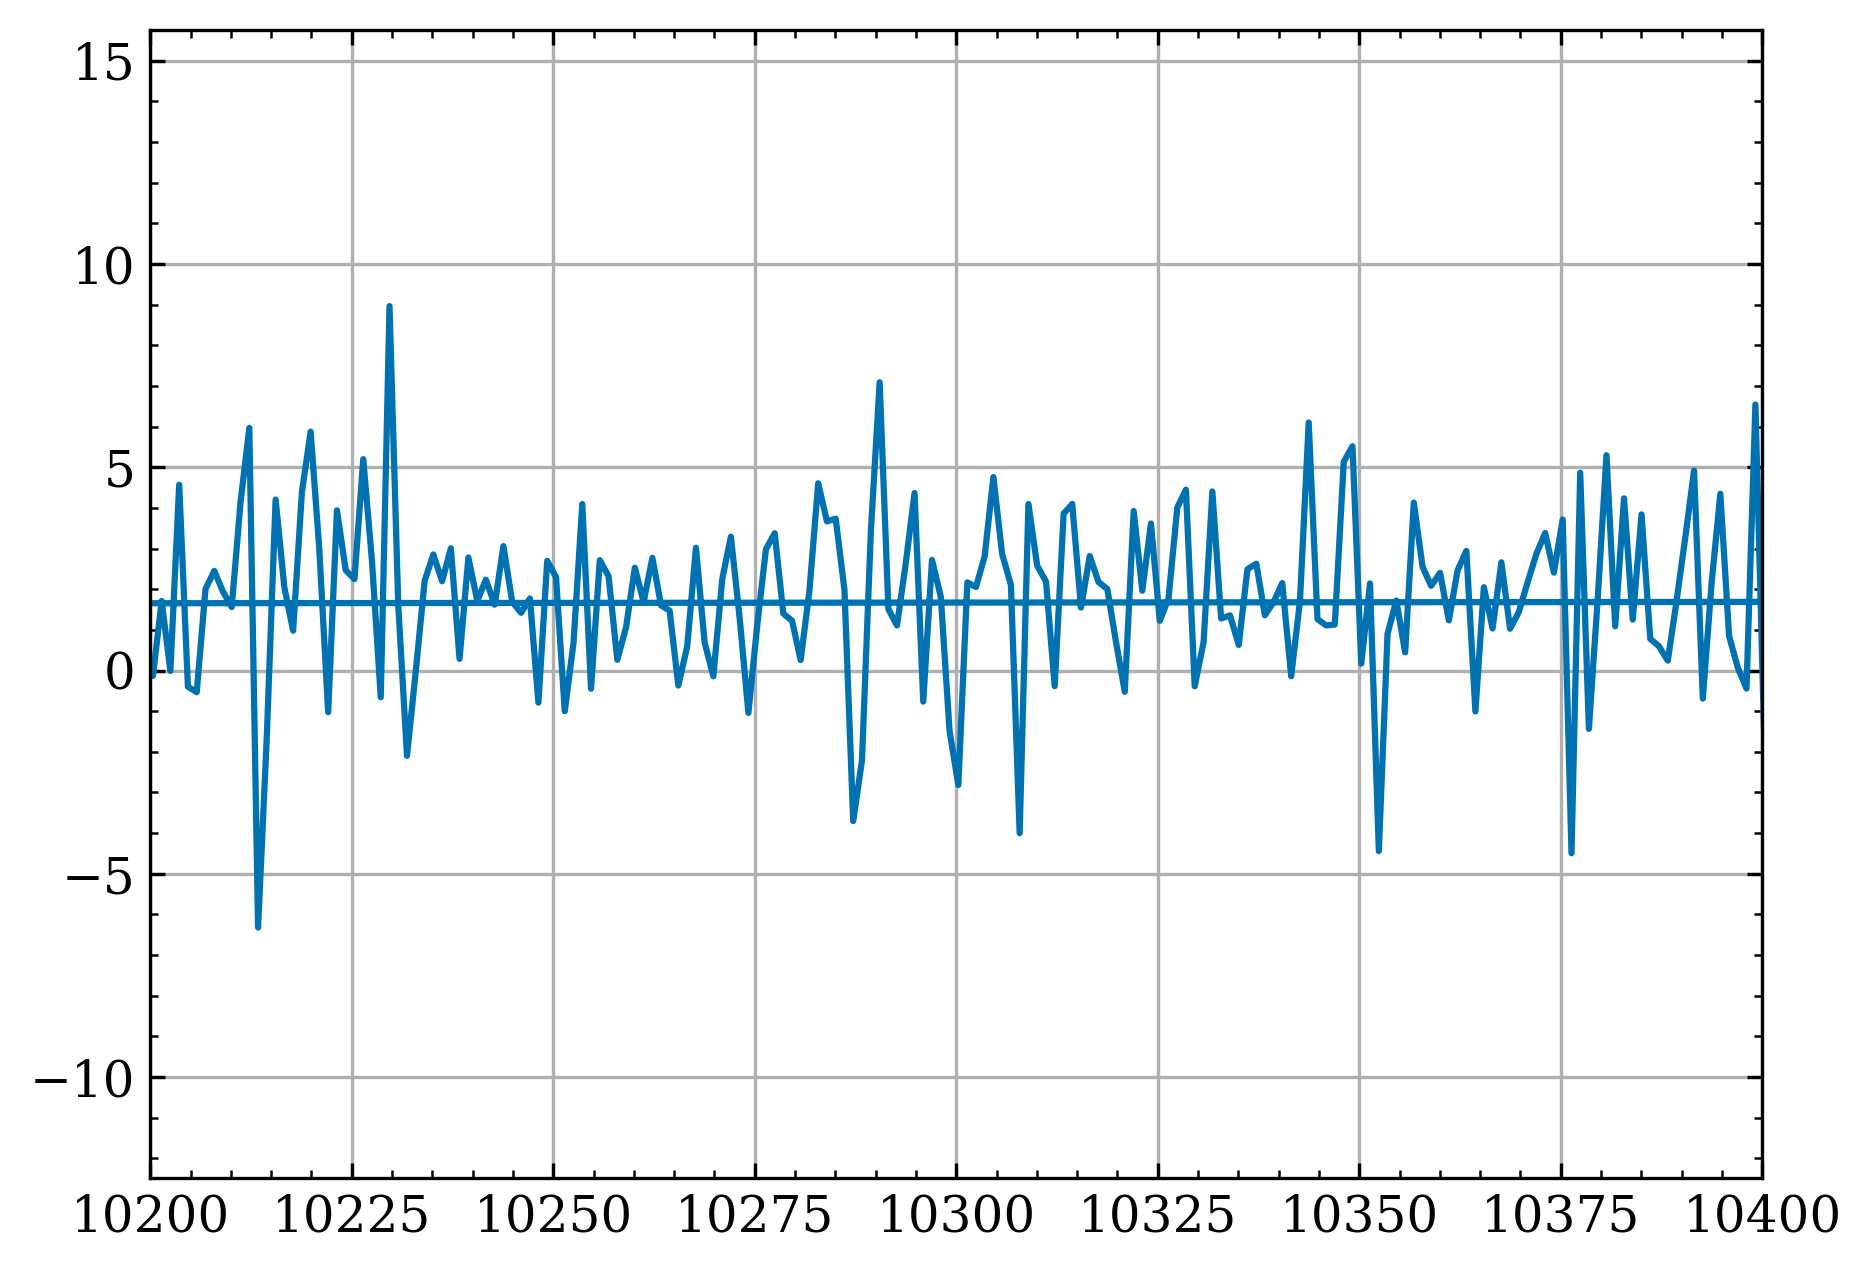

In [13]:
plt.plot(wave[0:,int(xcen)],signal[0:,int(xcen)])
plt.xlim(1.02e4,1.04e4)

In [14]:
def gaussian(xaxis, mean, A, sig, offset): 
	'''
	Simple Gaussian function, to be used in the quick optimized extraction
	'''
	return A * np.exp(-np.power(xaxis-mean, 2.) / (2*np.power(sig, 2.))) + offset

In [15]:
pixscale = hdu2[0].header['PSCALE'] # arcsec/pix
slitwidth = 2.5 # arcsec
nodamp = slitwidth/pixscale # nod amplitude in pixels

# gaussian smooth 2D spec
kernel = Gaussian2DKernel(x_stddev=1.)
conv_im = convolve(sig2d, kernel)

In [18]:
ddir = '../wmme01/mospy_products/wmme01_COMBINED_'
signal = fits.getdata(ddir + obj_name + '_eps.fits')

In [93]:
signal = sig2d

In [96]:
xcen

41

In [97]:
	aper = 7
	fwhm = 0.697 / pixscale # arcsec / [arcsec/pixel]
	gauss = gaussian(np.arange(aper),mean=3.,A=1.,sig=fwhm/2.35,offset=0.)
	gauss /= sum(gauss) # to make it sum to 1 to use as weights
	gauss_2D = np.zeros((len(gauss),len(wave))) # making 2D array of weights
	for i in range(aper):
		gauss_2D[i] = gauss[i]

In [99]:
gauss_2D.shape

(7, 2103)

In [104]:
wave.shape

(2103, 2764)

In [101]:
	# optimally-extracting 1D spectra
	half = int(aper/2) # to make the cut out of the 2D image
	spec = np.nansum(signal[xcen-half:xcen+half+1].copy()*gauss_2D,axis=0)
#	erropt = np.nansum(error[xcen-half:xcen+half+1].copy()*gauss_2D,axis=0)

In [103]:
signal.shape

(100, 2103)

In [77]:
# open 1D and 2D spectrum for an object
hdu2 = fits.open(ddir+obj_name+'_eps.fits') # mospy 2D spectrum file
image = hdu2[0].data # 2D spectrum array

wav, pix, spec, _, err, _ = exsp.extract1d(obj_name, ddir, ycen, FWHM=fwhm) # optimally extract 1D spectrum
rms = np.zeros_like(wav)



Reading in data for M_W69492
Dimensions: 	 signal spectrum (90, 1373)
		 error spectrum (90, 1373)


In [78]:
obj = obj_name
path = ddir

In [79]:
	# making sure the aperture is an odd number
	assert aper%2 == 1, "Aperture size needs to be an odd number of pixels. "\
		f"Currently, the aperture size is: \n \t\t  aper = {aper} pixels (default is 7 pixels)."

	# reading in data
	print(f'\nReading in data for {obj}')
	header = fits.getheader(path + obj + '_eps.fits')
	signal = fits.getdata(path + obj + '_eps.fits')
	error = fits.getdata(path + obj + '_sig.fits')

	print(f'Dimensions: \t signal spectrum {signal.shape}\n' +
			f'\t\t error spectrum {error.shape}')


Reading in data for M_W69492
Dimensions: 	 signal spectrum (90, 1373)
		 error spectrum (90, 1373)


In [80]:
FWHM = fwhm

In [81]:
	wavelength_start = header['CRVAL1'] # starting wavelength at first pixel
	wavelength_logdisp = header['CD1_1'] # delta wavelength per pixel
	num_wavelength = header['NAXIS1'] # length of data array
	wave = wavelength_start + np.arange(0, wavelength_logdisp*num_wavelength, wavelength_logdisp) # wavelength

In [82]:
len(wave)

1373

In [83]:
	# defining optimized extraction gaussian
	pixscale = header['PSCALE'] # arcsec/pix
	fwhm = FWHM / pixscale # arcsec / [arcsec/pixel]
	gauss = gaussian(np.arange(aper),mean=3.,A=1.,sig=fwhm/2.35,offset=0.)
	gauss /= sum(gauss) # to make it sum to 1 to use as weights
	gauss_2D = np.zeros((len(gauss),len(wave))) # making 2D array of weights
	for i in range(aper):
		gauss_2D[i] = gauss[i]

	# optimally-extracting 1D spectra
	half = int(aper/2) # to make the cut out of the 2D image
	spec = np.nansum(signal[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)
	erropt = np.nansum(error[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)

In [84]:
signal[ycen-half:ycen+half+1].shape

(7, 1373)

In [85]:
wave.shape

(1373,)

In [87]:
gauss_2D.shape, signal.shape

((7, 1373), (90, 1373))

In [ ]:
def extract1d(obj,path,ycen,FWHM,aper=7,width=4):
	'''
	Takes a mospy reduced MOS 2D image for a single object and manually extracts the 1D spectrum at a given y pixel using both boxcar and optimal extraction methods.
	
	INPUTS ---- obj:		str, name of the reduced 2D MOSFIRE file to be read in
		        path:		str, points to data directory
		        ycen:		int, row to extract spectrum on (pix)
                FWHM:		float, fwhm of star on mask (arcsec)
				aper:		int, number of rows to extract the 1D spectrum over
				width:		int, pixel width for boxcar box
				
	RETURNS --- wave:		wavelength array
                pix:		pixel array
		        spec:		optimal extracted spectral array
				specbox:	boxcar extracted spectral array
                err:		error from mospy sky spectrum
                rms:		background rms array
	'''

	# making sure the aperture is an odd number
	assert aper%2 == 1, "Aperture size needs to be an odd number of pixels. "\
		f"Currently, the aperture size is: \n \t\t  aper = {aper} pixels (default is 7 pixels)."

	# reading in data
	print(f'\nReading in data for {obj}')
	header = fits.getheader(path + obj + '_eps.fits')
	signal = fits.getdata(path + obj + '_eps.fits')
	error = fits.getdata(path + obj + '_sig.fits')

	print(f'Dimensions: \t signal spectrum {signal.shape}\n' +
			f'\t\t error spectrum {error.shape}')
	
    # wavelength array
	wavelength_start = header['CRVAL1'] # starting wavelength at first pixel
	wavelength_logdisp = header['CD1_1'] # delta wavelength per pixel
	num_wavelength = header['NAXIS1'] # length of data array
	wave = wavelength_start + np.arange(0, wavelength_logdisp*num_wavelength, wavelength_logdisp) # wavelength
    
    # pixel array
	pix_start = header['CRPIX1'] # starting pixel
	pix_logdisp = header['CD2_2'] # delta pixel per item
	num_pix = header['NAXIS1'] # length of data array
	pix = pix_start + np.arange(0, pix_logdisp*num_pix, pix_logdisp) # pixel

	# defining optimized extraction gaussian
	pixscale = header['PSCALE'] # arcsec/pix
	fwhm = FWHM / pixscale # arcsec / [arcsec/pixel]
	gauss = gaussian(np.arange(aper),mean=3.,A=1.,sig=fwhm/2.35,offset=0.)
	gauss /= sum(gauss) # to make it sum to 1 to use as weights
	gauss_2D = np.zeros((len(gauss),len(wave))) # making 2D array of weights
	for i in range(aper):
		gauss_2D[i] = gauss[i]

	# optimally-extracting 1D spectra
	half = int(aper/2) # to make the cut out of the 2D image
	spec = np.nansum(signal[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)
	erropt = np.nansum(error[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)
    
    # find background rms
	sigma_clip = SigmaClip(sigma=3.0) # define sigma clip
	bkgrms = StdBackgroundRMS(sigma_clip) # define background rms
	bkgrms_value = bkgrms.calc_background_rms(signal,axis=0) # create background rms array
	sky_idx = np.where(np.logical_and((bkgrms_value > np.nanmean(bkgrms_value)) == False, bkgrms_value > 0))[0] # find nonzero and non-skyline indices
	bkg = bkgrms_value.copy() # make copy of background array to do stuff on
	z3 = np.polyfit(wave[sky_idx],bkg[sky_idx],deg=3) # fit 3rd degree polynomial to wavelength and nonzero non-sky background
	fit3 = np.poly1d(z3) # function to evaluate the polynomial fit
	rms = fit3(wave) # evaluate the best fit function at the full wavelength array
    
	# boxcar extract 1D spec
	row1, row2 = ycen-width, ycen+width # define the target aperture range
	specbox = np.sum(signal[row1:row2, :], axis=0)
	errbox = np.sum(error[row1:row2, :], axis=0)
    
    # sky spectrum from mospy
	err = np.nanmedian(error, axis=0)
    
	return wave, pix, spec, specbox, err, rms

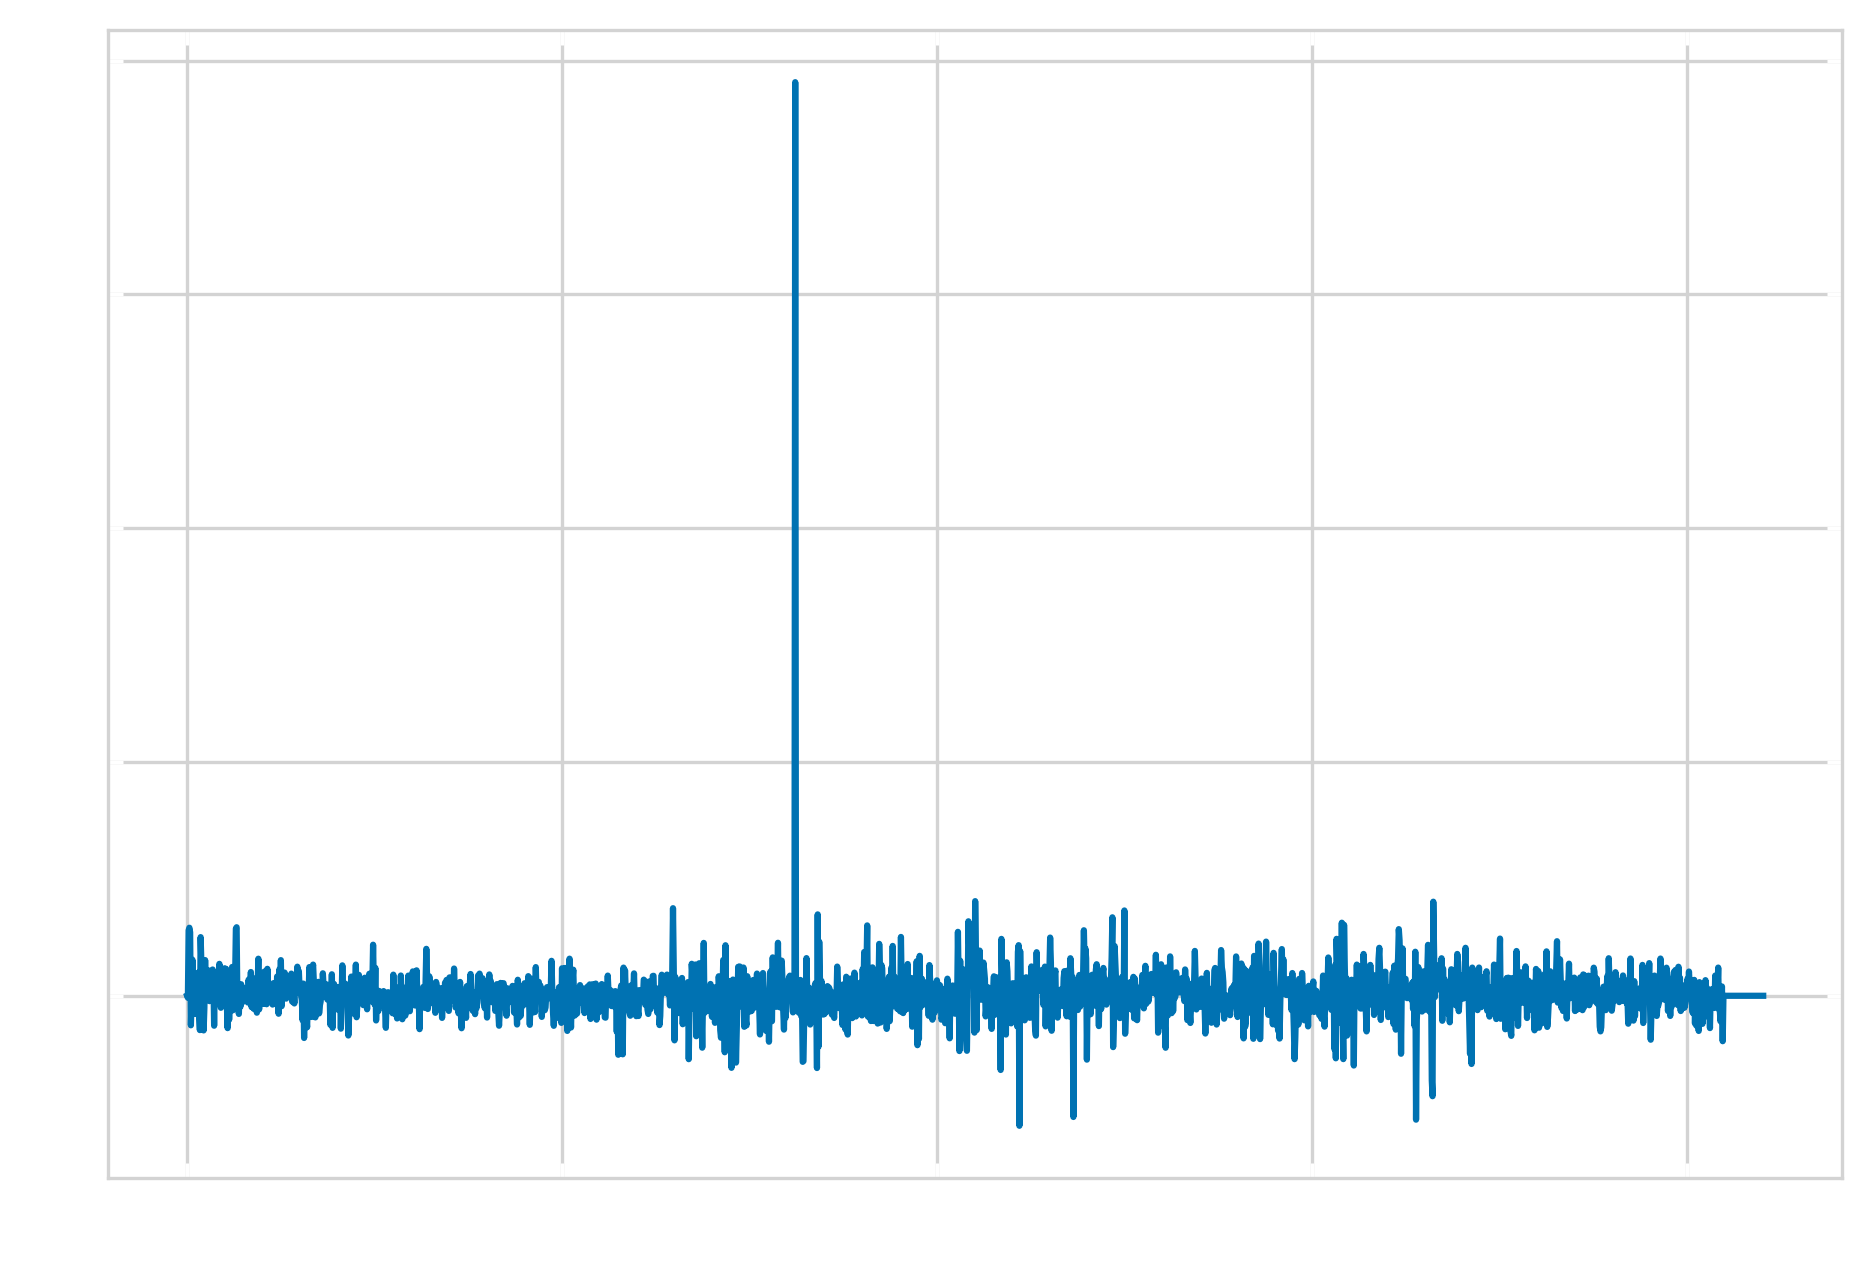

In [107]:
plt.plot(spec)

In [20]:
signal.shape

(90, 1373)

In [9]:
	fwhm = 0.697 / pixscale # arcsec / [arcsec/pixel]
	gauss = gaussian(np.arange(aper),mean=3.,A=1.,sig=fwhm/2.35,offset=0.)
	gauss /= sum(gauss) # to make it sum to 1 to use as weights
	gauss_2D = np.zeros((len(gauss),len(wave))) # making 2D array of weights
	for i in range(aper):
		gauss_2D[i] = gauss[i]

	# optimally-extracting 1D spectra
	half = int(aper/2) # to make the cut out of the 2D image
	spec = np.nansum(signal[xcen-half:xcen+half+1].copy()*gauss_2D,axis=0)
	erropt = np.nansum(error[xcen-half:xcen+half+1].copy()*gauss_2D,axis=0)
    
    # find background rms
	sigma_clip = SigmaClip(sigma=3.0) # define sigma clip
	bkgrms = StdBackgroundRMS(sigma_clip) # define background rms
	bkgrms_value = bkgrms.calc_background_rms(signal,axis=0) # create background rms array
	sky_idx = np.where(np.logical_and((bkgrms_value > np.nanmean(bkgrms_value)) == False, bkgrms_value > 0))[0] # find nonzero and non-skyline indices
	bkg = bkgrms_value.copy() # make copy of background array to do stuff on
	z3 = np.polyfit(wave[sky_idx],bkg[sky_idx],deg=3) # fit 3rd degree polynomial to wavelength and nonzero non-sky background
	fit3 = np.poly1d(z3) # function to evaluate the polynomial fit
	rms = fit3(wave) # evaluate the best fit function at the full wavelength array
    
	# boxcar extract 1D spec
	row1, row2 = ycen-width, ycen+width # define the target aperture range
	specbox = np.sum(signal[row1:row2, :], axis=0)
	errbox = np.sum(error[row1:row2, :], axis=0)
    
    # sky spectrum from mospy
	err = np.nanmedian(error, axis=0)

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-27.141357  ,   5.0057683 ,   0.90504533, ...,   0.        ,
          0.        ,   0.        ],
       [ 15.777384  ,   1.1676149 ,  17.935732  , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        , -23.57485   , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   4.7878866 , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , -10.077596  , ...,   0.        ,
          0.        ,   0.        ]], dtype=float32)

In [ ]:
plt.plot(wave[0:,xcen],spec,'k')

In [ ]:
pixscale = hdu2[0].header['PSCALE'] # arcsec/pix
slitwidth = 2.5 # arcsec
nodamp = slitwidth/pixscale # nod amplitude in pixels

# gaussian smooth 2D spec
kernel = Gaussian2DKernel(x_stddev=1.)
conv_im = convolve(sig2d, kernel)

### START FIG!
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

# 1D spec
ax1.plot(tab1['pix'],gaussian_filter1d(tab1['opt_counts'],sigma=1),c='MidnightBlue',label=obj_name)
ax1.plot(tab1['pix'],tab1['opt_counts'],c='MidnightBlue',ls='--',alpha=0.6) 
ax1.fill_between(tab1['pix'], y1=tab1['opt_sigma'], y2=-1*tab1['opt_sigma'], color='gray', label='sky')
ax1.set_ylabel(r'Flux')

# 2D spec
lower=-1; upper=2
sample = sigma_clip(sig2d) 
vmin = sample.mean() + lower * sample.std()
vmax = sample.mean() + upper * sample.std()
ax2.imshow(conv_im, origin='lower', cmap='bone', aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_xlabel('Column [Pix]')
ax2.set_ylabel('Row [Pix]')
ax2.grid(False)

# block out sky lines 2D
ipk = find_peaks(tab1['opt_sigma'], height=np.mean(tab1['opt_sigma']))[0]
for i in ipk:
    ax2.axvline(tab1['pix'][i],c='#4D4D6B',lw=15,alpha=0.85)

    
# secax = secondary axis for wavelength space
def forward(x):
    return np.interp(x, tab1['pix'], tab1['lambda'])

def inverse(x):
    return np.interp(x, tab1['lambda'], tab1['pix'])

secax = ax1.secondary_xaxis('top', functions=(forward, inverse))
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel(r'Wavelength [$\AA$]')

# mark measured line at pixel guess based on lambda guess
pguess = tab1['pix'][rmp.closest(tab1['lambda'],lguess)[0]] # pixel closest to wavelength of line to center on
s = tab1['opt_counts'][rmp.closest(tab1['lambda'],lguess)[0]] # signal closest to wavelength of line
n = tab1['opt_sigma'][rmp.closest(tab1['lambda'],lguess)[0]] # error closest to wavelength of line
sn = np.round(s/n,2)
print("candidate line at ",lguess,'AA; ',pguess,'pix')
print("detected at ",sn,' sigma')
ax1.axvline(pguess,lw=1,c='k',ls='-.',alpha=0.4)
ax2.axvline(pguess,lw=1,c='k',ls='-.',alpha=0.4)
ax2.axhline(xcen,lw=1,c='k',ls='-.',alpha=0.4)
ax2.axhline(xcen+nodamp,lw=1,c='k',ls=':',alpha=0.4)
ax2.axhline(xcen-nodamp,lw=1,c='k',ls=':',alpha=0.4)


ax1.set_xlim(pguess-70,pguess+70)
ax2.set_xlim(pguess-70,pguess+70)
ax1.set_ylim(-2*np.nanmedian(tab1['opt_sigma']),4*np.nanmedian(tab1['opt_sigma']))

#plt.show()
#plt.savefig('/Users/oc4858/Library/CloudStorage/Box-Box/werls/plots/'+obj_name+'_pypeit_1D_2D.png',dpi=500)


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 24 17:26:42 2022

Plot spectra from pypeit products

@author: 0cooper
"""

# the basics

import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clip
from scipy.signal import find_peaks
import read_mospy_files as rmp 
import glob
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from scipy.ndimage import gaussian_filter1d
plt.style.use('../cooper-paper.mplstyle')

# select object
obj_name = 'M_W69492'
notes = Table.read('cooper_full_notes.csv',format='csv')
idx = np.where(notes['obj']==obj_name)[0]
zguess = float(notes['zguess'][idx])
lguess = float(notes['wave'][idx])
print('working on object',obj_name,'with zguess = ',zguess,'at lambda = ',lguess,'AA')

if notes['mask'][idx] == 'wmmc01':
    ddir = '../wmmc01/'
elif notes['mask'][idx] == 'wmmc02':
    ddir = '../wmmc02/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmmc03':
    ddir = '../wmmc03/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmmc05':
    ddir = '../wmmc05/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmmc06':
    ddir = '../wmmc06/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmmu01':
    ddir = '../wmmu01/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmme01':
    ddir = '../wmme01/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmme02':
    ddir = '../wmme02/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmme03':
    ddir = '../wmme03/pypeit_products/Science_coadd_1x1/'
        
### add the other masks


# open 1D and 2D spectrum for an object
tab1 = Table.read(ddir+obj_name+'_1dspec.txt',format='ascii') # created 1d spec txt file from read_pypeit_files.py
file = glob.glob(ddir+'spec2d*.fits')[0] # 2d pypeit image
hdu2 = fits.open(file) # open image
pid = int(notes['pypeit_ref_idx'][idx])-1 # pypeit id to identify the slit
header = hdu2[0].header # header info
signal = hdu2[1].data # signal image data
ref = hdu2[10].data[pid] # reference to slit in 2d image
print('check this is the right source:',ref)
x1 = ref[4][0] # left side of slit
x2 = ref[5][0] # right side of slit
xcen = ref[2] # object
sig2d = signal[0:,int(x1):int(x2)].T # signal for the slit (transposed)

working on object M_W69492 with zguess =  7.4775 at lambda =  10304.0 AA
check this is the right source: (2289, 6, 41.0, array([50., 50., 50., ..., 50., 50., 50.]), array([2239., 2239., 2239., ..., 2239., 2239., 2239.]), array([2339., 2339., 2339., ..., 2339., 2339., 2339.]), array([2289., 2289., 2289., ..., 2289., 2289., 2289.]), 0, 0, 0.0, 2047.0)


candidate line at  10304.0 AA;  1043 pix
detected at  2.49  sigma


(-7.536516095426446, 15.073032190852892)

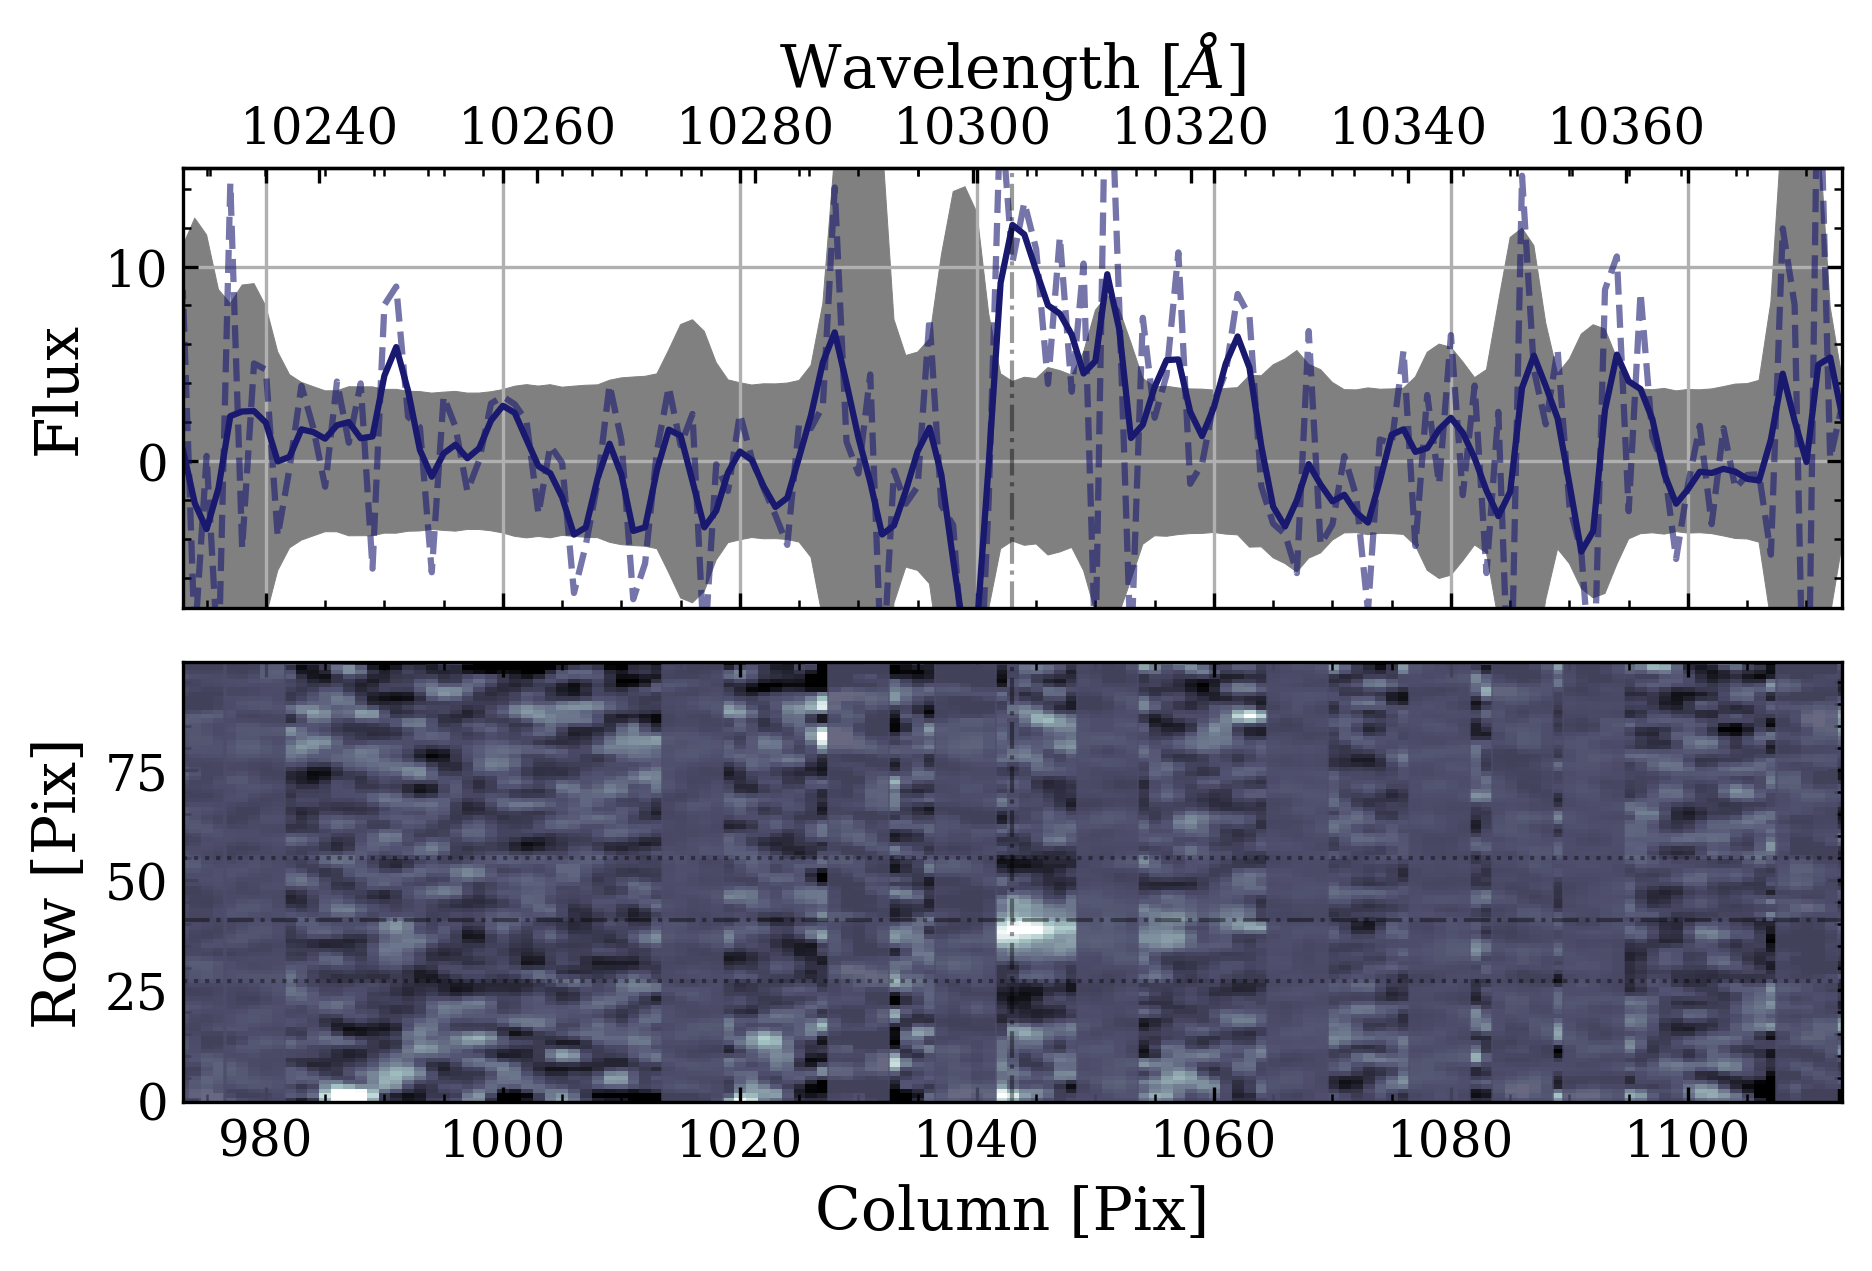

In [3]:

pixscale = hdu2[0].header['PSCALE'] # arcsec/pix
slitwidth = 2.5 # arcsec
nodamp = slitwidth/pixscale # nod amplitude in pixels

# gaussian smooth 2D spec
kernel = Gaussian2DKernel(x_stddev=1.)
conv_im = convolve(sig2d, kernel)

### START FIG!
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

# 1D spec
ax1.plot(tab1['pix'],gaussian_filter1d(tab1['opt_counts'],sigma=1),c='MidnightBlue',label=obj_name)
ax1.plot(tab1['pix'],tab1['opt_counts'],c='MidnightBlue',ls='--',alpha=0.6) 
ax1.fill_between(tab1['pix'], y1=tab1['opt_sigma'], y2=-1*tab1['opt_sigma'], color='gray', label='sky')
ax1.set_ylabel(r'Flux')

# 2D spec
lower=-1; upper=2
sample = sigma_clip(sig2d) 
vmin = sample.mean() + lower * sample.std()
vmax = sample.mean() + upper * sample.std()
ax2.imshow(conv_im, origin='lower', cmap='bone', aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_xlabel('Column [Pix]')
ax2.set_ylabel('Row [Pix]')
ax2.grid(False)

# block out sky lines 2D
ipk = find_peaks(tab1['opt_sigma'], height=np.mean(tab1['opt_sigma']))[0]
for i in ipk:
    ax2.axvline(tab1['pix'][i],c='#4D4D6B',lw=15,alpha=0.85)

    
# secax = secondary axis for wavelength space
def forward(x):
    return np.interp(x, tab1['pix'], tab1['lambda'])

def inverse(x):
    return np.interp(x, tab1['lambda'], tab1['pix'])

secax = ax1.secondary_xaxis('top', functions=(forward, inverse))
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel(r'Wavelength [$\AA$]')

# mark measured line at pixel guess based on lambda guess
pguess = tab1['pix'][rmp.closest(tab1['lambda'],lguess)[0]] # pixel closest to wavelength of line to center on
s = tab1['opt_counts'][rmp.closest(tab1['lambda'],lguess)[0]] # signal closest to wavelength of line
n = tab1['opt_sigma'][rmp.closest(tab1['lambda'],lguess)[0]] # error closest to wavelength of line
sn = np.round(s/n,2)
print("candidate line at ",lguess,'AA; ',pguess,'pix')
print("detected at ",sn,' sigma')
ax1.axvline(pguess,lw=1,c='k',ls='-.',alpha=0.4)
ax2.axvline(pguess,lw=1,c='k',ls='-.',alpha=0.4)
ax2.axhline(xcen,lw=1,c='k',ls='-.',alpha=0.4)
ax2.axhline(xcen+nodamp,lw=1,c='k',ls=':',alpha=0.4)
ax2.axhline(xcen-nodamp,lw=1,c='k',ls=':',alpha=0.4)


ax1.set_xlim(pguess-70,pguess+70)
ax2.set_xlim(pguess-70,pguess+70)
ax1.set_ylim(-2*np.nanmedian(tab1['opt_sigma']),4*np.nanmedian(tab1['opt_sigma']))


In [4]:
def gaussian(xaxis, mean, A, sig, offset): 
	'''
	Simple Gaussian function, to be used in the quick optimized extraction
	'''
	return A * np.exp(-np.power(xaxis-mean, 2.) / (2*np.power(sig, 2.))) + offset


In [ ]:
def extract1d(obj,path,ycen,FWHM,aper=7,width=4):
	'''
	Takes a mospy reduced MOS 2D image for a single object and manually extracts the 1D spectrum at a given y pixel using both boxcar and optimal extraction methods.
	
	INPUTS ---- obj:		str, name of the reduced 2D MOSFIRE file to be read in
		        path:		str, points to data directory
		        ycen:		int, row to extract spectrum on (pix)
                FWHM:		float, fwhm of star on mask (arcsec)
				aper:		int, number of rows to extract the 1D spectrum over
				width:		int, pixel width for boxcar box
				
	RETURNS --- wave:		wavelength array
                pix:		pixel array
		        spec:		optimal extracted spectral array
				specbox:	boxcar extracted spectral array
                err:		error from mospy sky spectrum
                rms:		background rms array
	'''

	# making sure the aperture is an odd number
	assert aper%2 == 1, "Aperture size needs to be an odd number of pixels. "\
		f"Currently, the aperture size is: \n \t\t  aper = {aper} pixels (default is 7 pixels)."

	# reading in data
	print(f'\nReading in data for {obj}')
	header = fits.getheader(path + obj + '_eps.fits')
	signal = fits.getdata(path + obj + '_eps.fits')
	error = fits.getdata(path + obj + '_sig.fits')
    
file = glob.glob(ddir+'spec2d*.fits')[0] # 2d pypeit image
hdu2 = fits.open(file) # open image
pid = int(notes['pypeit_ref_idx'][idx])-1 # pypeit id to identify the slit
header = hdu2[0].header # header info
signal = hdu2[1].data # signal image data
ref = hdu2[10].data[pid] # reference to slit in 2d image
print('check this is the right source:',ref)
x1 = ref[4][0] # left side of slit
x2 = ref[5][0] # right side of slit
xcen = ref[2] # object
sig2d = signal[0:,int(x1):int(x2)].T # signal for the slit (transposed)

	print(f'Dimensions: \t signal spectrum {signal.shape}\n' +
			f'\t\t error spectrum {error.shape}')
	
    # wavelength array
	wavelength_start = header['CRVAL1'] # starting wavelength at first pixel
	wavelength_logdisp = header['CD1_1'] # delta wavelength per pixel
	num_wavelength = header['NAXIS1'] # length of data array
	wave = wavelength_start + np.arange(0, wavelength_logdisp*num_wavelength, wavelength_logdisp) # wavelength
    
    # pixel array
	pix_start = header['CRPIX1'] # starting pixel
	pix_logdisp = header['CD2_2'] # delta pixel per item
	num_pix = header['NAXIS1'] # length of data array
	pix = pix_start + np.arange(0, pix_logdisp*num_pix, pix_logdisp) # pixel

	# defining optimized extraction gaussian
	pixscale = header['PSCALE'] # arcsec/pix
	fwhm = FWHM / pixscale # arcsec / [arcsec/pixel]
	gauss = gaussian(np.arange(aper),mean=3.,A=1.,sig=fwhm/2.35,offset=0.)
	gauss /= sum(gauss) # to make it sum to 1 to use as weights
	gauss_2D = np.zeros((len(gauss),len(wave))) # making 2D array of weights
	for i in range(aper):
		gauss_2D[i] = gauss[i]

	# optimally-extracting 1D spectra
	half = int(aper/2) # to make the cut out of the 2D image
	spec = np.nansum(signal[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)
	erropt = np.nansum(error[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)
    
    # find background rms
	sigma_clip = SigmaClip(sigma=3.0) # define sigma clip
	bkgrms = StdBackgroundRMS(sigma_clip) # define background rms
	bkgrms_value = bkgrms.calc_background_rms(signal,axis=0) # create background rms array
	sky_idx = np.where(np.logical_and((bkgrms_value > np.nanmean(bkgrms_value)) == False, bkgrms_value > 0))[0] # find nonzero and non-skyline indices
	bkg = bkgrms_value.copy() # make copy of background array to do stuff on
	z3 = np.polyfit(wave[sky_idx],bkg[sky_idx],deg=3) # fit 3rd degree polynomial to wavelength and nonzero non-sky background
	fit3 = np.poly1d(z3) # function to evaluate the polynomial fit
	rms = fit3(wave) # evaluate the best fit function at the full wavelength array
    
	# boxcar extract 1D spec
	row1, row2 = ycen-width, ycen+width # define the target aperture range
	specbox = np.sum(signal[row1:row2, :], axis=0)
	errbox = np.sum(error[row1:row2, :], axis=0)
    
    # sky spectrum from mospy
	err = np.nanmedian(error, axis=0)
    
	return wave, pix, spec, specbox, err, rms

In [1]:
def pypextract1d(obj,path,xoff,FWHM,aper=7,width=4):
    '''
    Takes a PypeIt reduced MOS 2D image for a single object and manually extracts the 1D spectrum at a given x pixel using optimal extraction methods.

    INPUTS ---- obj:		str, name of the reduced 2D MOSFIRE file to be read in
                path:		str, points to data directory
                xoff:		int, offset from original pypeit xcen to extract spectrum on (pix)
                FWHM:		float, fwhm of star on mask (arcsec)
                aper:		int, number of rows to extract the 1D spectrum over
                width:		int, pixel width for boxcar box

    RETURNS --- spec:		optimal extracted spectral array
                specbox:	boxcar extracted spectral array
    '''
    
    # making sure the aperture is an odd number
    assert aper%2 == 1, "Aperture size needs to be an odd number of pixels. "\
    f"Currently, the aperture size is: \n \t\t  aper = {aper} pixels (default is 7 pixels)."

    # select object
    notes = Table.read('cooper_full_notes.csv',format='csv')
    idx = np.where(notes['obj']==obj)[0]

    # read in data
    file = glob.glob(path+'spec2d*.fits')[0] # 2d pypeit image
    hdu2 = fits.open(file) # open image
    pid = int(notes['pypeit_ref_idx'][idx])-1 # pypeit id to identify the slit
    header = hdu2[0].header # header info
    signal = hdu2[1].data # signal image data
    wave = hdu2[8].data # wave image data
    ref = hdu2[10].data[pid] # reference to slit in 2d image
    x1 = ref[4][0] # left side of slit
    x2 = ref[5][0] # right side of slit
    xcen_pypeit = ref[2] # where pypeit thinks the object is
    sig2d = signal[0:,int(x1):int(x2)].T # signal for the slit (transposed)

    # xcenter
    xcen = int(xcen_pypeit+xoff)
    print('xcen = ',xcen)
    print(f'Dimensions: \t signal spectrum {signal.shape}\n')

    # defining optimized extraction gaussian
    pixscale = header['PSCALE'] # arcsec/pix
    fwhm = FWHM / pixscale # arcsec / [arcsec/pixel]
    gauss = gaussian(np.arange(aper),mean=3.,A=1.,sig=fwhm/2.35,offset=0.)
    gauss /= sum(gauss) # to make it sum to 1 to use as weights
    gauss_2D = np.zeros((len(gauss),len(wave))) # making 2D array of weights
    for i in range(aper):
        gauss_2D[i] = gauss[i]

    # optimally-extracting 1D spectra
    half = int(aper/2) # to make the cut out of the 2D image
    spec = np.nansum(sig2d[xcen-half:xcen+half+1].copy()*gauss_2D,axis=0)
    
    # boxcar extract 1D spec
    row1, row2 = xcen-width, xcen+width # define the target aperture range
    specbox = np.sum(sig2d[row1:row2, :], axis=0)
    
    return spec, specbox

In [2]:
sp,spb = pypextract1d(obj=obj_name,path=ddir,xoff=0,FWHM=0.697,aper=7)

NameError: name 'obj_name' is not defined

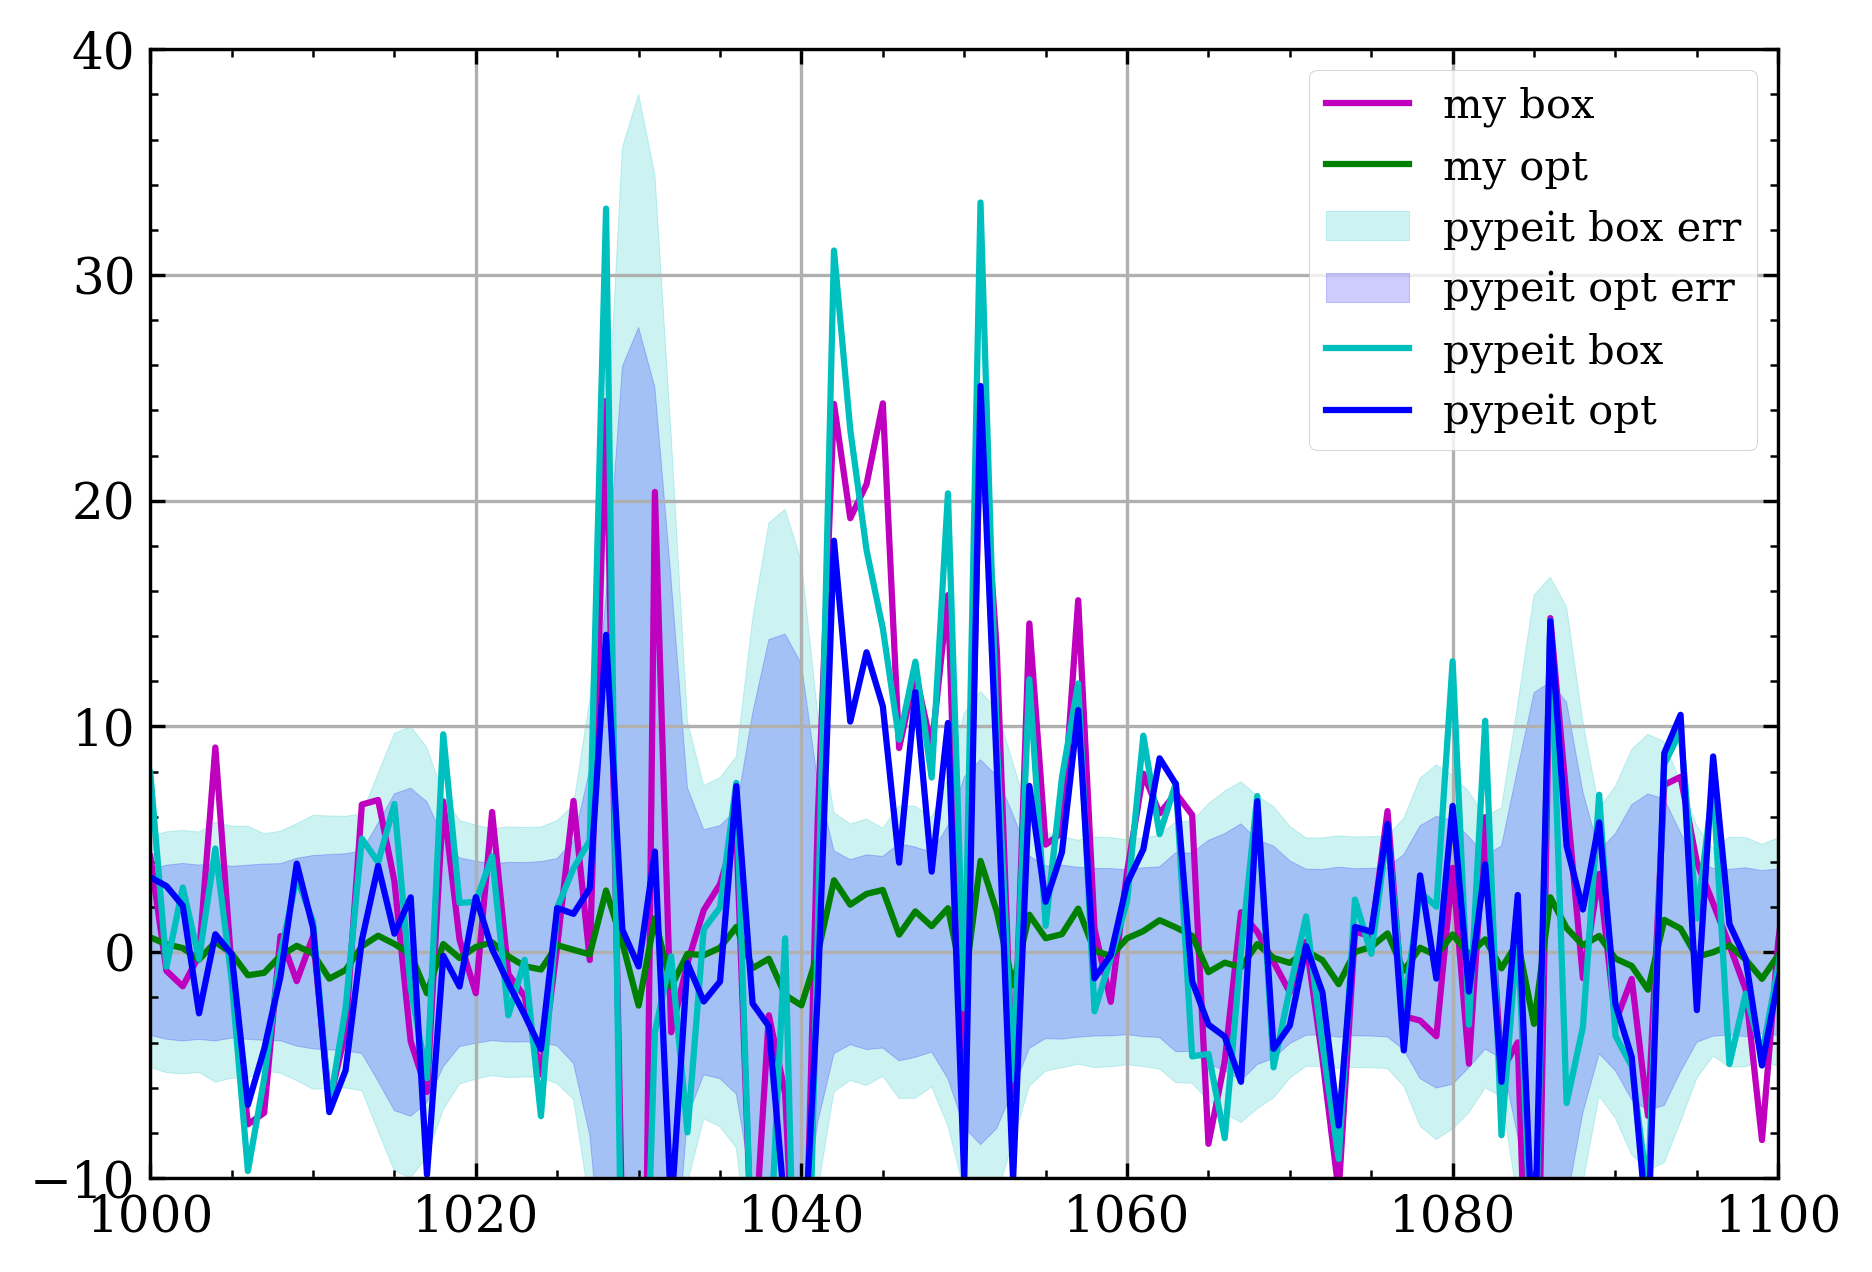

In [117]:
tab1 = Table.read(ddir+obj_name+'_1dspec.txt',format='ascii') # created 1d spec txt file from read_pypeit_files.py
# 1D spec
plt.plot(spb,c='m',label='my box')
plt.plot(sp,c='g',label='my opt')
plt.fill_between(tab1['pix'], y1=tab1['box_sigma'], y2=-1*tab1['box_sigma'], color='c',alpha=0.2,label='pypeit box err')
plt.fill_between(tab1['pix'], y1=tab1['opt_sigma'], y2=-1*tab1['opt_sigma'], color='b',alpha=0.2,label='pypeit opt err')
plt.plot(tab1['pix'],tab1['box_counts'],c='c',label='pypeit box') 

plt.plot(tab1['pix'],tab1['opt_counts'],c='b',label='pypeit opt')
plt.xlim(1000,1100)
plt.ylim(-10,40)
plt.legend()